# Publication-Ready GWAS: An Automated & Comprehensive Pipeline
This notebook provides a start-to-finish workflow for performing a Genome-Wide Association Study (GWAS). It is designed to be robust, automated, and highly configurable, suitable for producing publication-ready results.

### Key Features:
- **Automated Data Handling**: Seamlessly handles both CSV and PLINK formats. Automatically converts large CSV files to the memory-efficient PLINK binary format to prevent crashes.
- **Comprehensive & Interactive QC**: Implements a rigorous Quality Control (QC) pipeline that generates detailed reports on sample and SNP dropout at each step. Includes interactive tables for exploring QC results.
- **Enhanced Phenotype QC**: Includes checks for phenotype distribution and normality, automated transformation for skewed data, and optional outlier removal for robust analysis.
- **Robust SNP Metadata Handling**: Implements detailed parsing and validation of SNP identifiers, ensuring accurate chromosome and position information, and handling various formats and potential issues.
- **Flexible GWAS Models**: Runs multiple GWAS models to account for various confounding factors:
    - **Naive GLM**: A basic model for baseline comparison.
    - **PCA-Corrected GLM**: Corrects for population stratification.
    - **Linear Mixed Model (LMM)**: Corrects for both population structure and cryptic relatedness.
    - **Leave-One-Chromosome-Out (LOCO) LMM**: The gold standard, avoiding proximal contamination for more accurate results.
- **Automated Reporting & Interpretation**:
    - Generates publication-quality Manhattan and QQ plots.
    - Calculates genomic inflation (λ) to assess model fit.
    - Provides automated recommendations for the best model to interpret based on data quality and model calibration.
    - Includes clear flags for common issues like high dropout rates or model inflation.
- **Benchmarking**: Optional tools to measure runtime and memory usage.

### How to Use:
1.  **Configure Parameters**: Set file paths, QC thresholds, and model choices in **Step 1**.
2.  **Run All Cells**: Execute the notebook from top to bottom.
3.  **Review Results**: Analyze the generated plots, QC reports, and final recommendations to draw conclusions.


**NOTE:** If you are providing genotype data in CSV format and the file size exceeds the `LARGE_FILE_THRESHOLD_MB`, the pipeline will automatically attempt to convert it to PLINK binary format for efficiency. **For this conversion to work, you must have the PLINK executable installed and accessible in your environment's PATH.** You can typically install PLINK by downloading it from the official website and placing the executable in a directory included in your system's PATH, or by installing it directly within the notebook environment if possible (e.g., using a shell command like `!apt-get install plink` or `!conda install -c bioconda plink` depending on your environment).

#### --- **1. CONFIGURATION** ---
#### Set all your analysis parameters in this cell.


In [17]:
# NOTE: Format for csv genotype files:  rows=samples, columns=SNPs, first col 'Sample'
# NOTE: Format for csv phenotype file : columns: 'Sample', 'trait_name'
# You can check out the sample files in the repo to check the required format for input csv files

# --- Input / Output Files ---
# NOTE: For PLINK format, provide the path prefix (without .bed, .bim, or .fam)
GENO_PATH = 'genotype_sample.csv'  # Example: 'data/test_data/plink_example' or 'data/test_data/csv_example.csv'
GENO_FORMAT = 'csv'            # 'plink' or 'csv'
PHENO_PATH = 'phenotype_sample.csv' # Example: 'data/test_data/pheno_example.csv'
TRAIT_NAME = 'Trait_Name'      # The column name of the phenotype to be analyzed
OUTPUT_PREFIX = 'GWAS_Sample_Test' # Directory and file prefix for all outputs

LARGE_FILE_THRESHOLD_MB = 50   # Switch to optimized loading above this size
CSV_CHUNK_SIZE = 10000         # Rows per chunk for chunked loading, customize according to your RAM capacity

# --- Quality Control (QC) Parameters ---
MAF_THRESHOLD = 0.01
IMPUTATION_METHOD = 'mean'     # 'mean', 'median', or 'knn'
MIN_SNPS_PER_CHROMOSOME = 2    # Minimum SNPs required per chromosome otherwise assigned to chromosome 0

# --- Phenotype QC Parameters ---
REMOVE_PHENOTYPE_OUTLIERS = True # Set to False to skip outlier removal
OUTLIER_METHOD = 'iqr'         # 'iqr' or 'zscore'
OUTLIER_THRESHOLD = 1.5        # For IQR: 1.5 (conservative) or 3.0 (lenient); For zscore: typically 3.0

# --- Analysis Parameters ---
AUTO_SELECT_PCS = True         # Set to True to let the script find the optimal number of PCs. If False, it will use the value from NUM_PCS.
NUM_PCS = 10                   # Used only if AUTO_SELECT_PCS is False.

SIGNIFICANCE_ALPHA = 0.05      # Significance level for FDR

# --- Model Selection ---
# Choose which models to run. It's recommended to run all for comparison.
RUN_NAIVE_GLM = True           #Naive GLM without covariates
RUN_PCA_GLM = True             # GLM with PCA covariates
RUN_LMM = True                 # Linear Mixed Model (LMM) with kinship matrix
RUN_LOCO_LMM = True            # Leave-One-Chromosome-Out LMM (LOCO) Note: This is the most computationally intensive model.

# --- Workflow Behavior ---
# Set to True to see phenotype distribution plot and normality test before running GWAS.
CHECK_PHENOTYPE_DISTRIBUTION = True
TRANSFORM_PHENOTYPE_IF_SKEWED = True

BENCHMARK = True               # Set to True to track execution time and memory usage.



#### **2. IMPORTS & HELPER FUNCTIONS**
#### This cell imports necessary libraries and defines utility functions for logging and formatting.

In [18]:

import time
import re
import gc
import sys
import tracemalloc
from pathlib import Path
import csv
import os
import subprocess

import pandas as pd
import numpy as np
from pandas_plink import read_plink1_bin #NOTE: pandas_plink requires numpy version to be between 1.0 and 2.0
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from scipy import stats
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted, ns

# --- Utility Functions ---

def log_message(message, level="INFO"):
    """Prints a formatted log message."""
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] [{level}] {message}")

def format_bytes(size):
    """Formats memory size into a human-readable string."""
    power = 1024
    n = 0
    power_labels = {0: '', 1: 'K', 2: 'M', 3: 'G', 4: 'T'}
    while size > power and n < len(power_labels):
        size /= power
        n += 1
    return f"{size:.2f} {power_labels[n]}B"

# Start the clock and memory tracker
start_time = time.time()
if BENCHMARK:
    tracemalloc.start()


#### **3. PIPELINE CORE FUNCTIONS**
#### *This cell contains the core logic for data loading, QC, PCA, and the GWAS models.*


**Key features:**
- Automatic file size check and conversion for large CSVs
- Robust sample alignment between genotype and phenotype
- SNP metadata parsing for chromosome and position extraction
- Ready for comprehensive QC

In [19]:
# ==============================================================================
# --- DATA LOADING, CONVERSION & PREPARATION ---
# ==============================================================================

def load_genotypes(file_path, file_format):
    """Loads genotype data from either CSV or PLINK format."""
    log_message(f"Loading genotypes from '{file_path}' (format: {file_format})...")

    if file_format.lower() == 'csv':
        # Check file size
        file_size = Path(file_path).stat().st_size / 1024**2  # Size in MB
        log_message(f"CSV file size: {file_size:.1f} MB")

        # Quick check of number of columns
        with open(file_path, 'r') as f:
            first_line = f.readline()
            n_cols = len(first_line.split(','))

        log_message(f"File has {n_cols} columns")

        if n_cols > 10000 or file_size > 500:  # Large number of SNPs or large file
            log_message("Large file/many SNPs detected. Using column-wise chunked loading...")
            return load_genotypes_selective_columns(file_path, max_snps_per_chunk=20000)
        else:
            log_message("Using standard optimized loading...")
            # Your existing optimized loading
            header_df = pd.read_csv(file_path, nrows=0)
            dtypes = {col: 'Int8' for col in header_df.columns[1:]}
            geno_df = pd.read_csv(file_path, dtype=dtypes, index_col=0,
                                engine='c', na_values=['NA', 'nan', '', '.', '-9'])
            snp_metadata = pd.DataFrame({'SNP_ID': geno_df.columns})
            return geno_df, snp_metadata

    elif file_format.lower() == 'plink':
        try:
            # Check if files exist
            bed_file = f"{file_path}.bed"
            bim_file = f"{file_path}.bim"
            fam_file = f"{file_path}.fam"

            for file in [bed_file, bim_file, fam_file]:
                if not Path(file).exists():
                    raise FileNotFoundError(f"Required PLINK file not found: {file}")

            log_message("Reading PLINK binary files...")

            # Load the PLINK data using pandas-plink
            from pandas_plink import read_plink1_bin
            G_dask = read_plink1_bin(bed_file, verbose=False)

            # Extract genotype values
            if hasattr(G_dask, 'values'):
                if hasattr(G_dask.values, 'compute'):
                    geno_values = G_dask.values.compute()
                else:
                    geno_values = G_dask.values
            else:
                geno_values = G_dask

            # Extract sample IDs (from FAM file via pandas-plink)
            if hasattr(G_dask, 'iid'):
                sample_ids = G_dask.iid.values.astype(str)
            else:
                # Fallback: read FAM file directly
                log_message("Reading sample IDs from FAM file...")
                fam_df = pd.read_csv(fam_file, sep='\s+', header=None, usecols=[1])
                sample_ids = fam_df[1].astype(str).values

            # Extract SNP IDs and chromosome/position info from pandas-plink object
            if hasattr(G_dask, 'snp'):
                snp_ids = G_dask.snp.values.astype(str)
            else:
                # Fallback: read BIM file directly
                log_message("Reading SNP IDs from BIM file...")
                bim_df = pd.read_csv(bim_file, sep='\s+', header=None, usecols=[1])
                snp_ids = bim_df[1].astype(str).values

            # Extract chromosome and position information directly from pandas-plink
            if hasattr(G_dask, 'chrom') and hasattr(G_dask, 'pos'):
                log_message("Extracting chromosome and position information from pandas-plink object...")
                chromosomes = G_dask.chrom.values.astype(str)
                positions = G_dask.pos.values
                log_message(f"Found chromosome info: {len(set(chromosomes))} unique chromosomes")
                log_message(f"Chromosome examples: {sorted(set(chromosomes))[:10]}")
            else:
                # Fallback: read from BIM file
                log_message("Reading chromosome and position from BIM file...")
                bim_df = pd.read_csv(bim_file, sep='\s+', header=None,
                                     names=['chrom', 'SNP_ID', 'cm', 'pos', 'a1', 'a2'])
                chromosomes = bim_df['chrom'].astype(str).values
                positions = bim_df['pos'].values

            # Verify dimensions match
            log_message(f"Data dimensions: {geno_values.shape[0]} samples × {geno_values.shape[1]} SNPs")
            log_message(f"Sample IDs: {len(sample_ids)}, SNP IDs: {len(snp_ids)}")
            log_message(f"Chromosome info: {len(chromosomes)}, Position info: {len(positions)}")

            if geno_values.shape[0] != len(sample_ids):
                raise ValueError(f"Sample count mismatch: genotype matrix has {geno_values.shape[0]} rows but {len(sample_ids)} sample IDs")
            if geno_values.shape[1] != len(snp_ids):
                raise ValueError(f"SNP count mismatch: genotype matrix has {geno_values.shape[1]} columns but {len(snp_ids)} SNP IDs")
            if len(chromosomes) != len(snp_ids):
                raise ValueError(f"Chromosome info mismatch: {len(chromosomes)} chromosome entries but {len(snp_ids)} SNPs")
            if len(positions) != len(snp_ids):
                raise ValueError(f"Position info mismatch: {len(positions)} position entries but {len(snp_ids)} SNPs")

            # Create genotype DataFrame
            geno_df = pd.DataFrame(
                geno_values,
                index=sample_ids,
                columns=snp_ids
            )

            # Create comprehensive SNP metadata DataFrame directly from pandas-plink data
            log_message("Creating SNP metadata from pandas-plink data...")
            snp_metadata_df = pd.DataFrame({
                'SNP_ID': snp_ids,
                'chrom': chromosomes,
                'pos': positions
            })

            log_message(f"Successfully loaded {geno_df.shape[1]} SNPs for {geno_df.shape[0]} samples from PLINK files.")
            log_message(f"Chromosome distribution: {snp_metadata_df['chrom'].value_counts().to_dict()}")

            return geno_df, snp_metadata_df

        except ImportError:
            log_message("pandas-plink not installed. Install with: pip install pandas-plink", "ERROR")
            raise ImportError("pandas-plink is required for PLINK format. Install with: pip install pandas-plink")
        except Exception as e:
            log_message(f"PLINK file loading error: {e}", "ERROR")
            log_message(f"Ensure these files exist: {file_path}.bed, {file_path}.bim, {file_path}.fam", "ERROR")
            raise e

    else:
        raise ValueError("Unsupported genotype file format. Use 'csv' or 'plink'.")

def load_phenotypes(file_path, trait_name):
    """Loads and cleans phenotype data."""
    log_message(f"Loading phenotypes from '{file_path}' for trait '{trait_name}'...")
    pheno_df = pd.read_csv(file_path)
    pheno_df = pheno_df.set_index(pheno_df.columns[0])
    if trait_name not in pheno_df.columns:
        log_message(f"Trait '{trait_name}' not found in phenotype file.", "ERROR")
        raise KeyError(f"Trait '{trait_name}' not found.")
    y = pd.to_numeric(pheno_df[trait_name], errors='coerce').rename('phenotype')
    log_message(f"Loaded {y.count()} non-missing phenotype records.")
    return y

def check_phenotype_distribution(y, trait_name="Phenotype"):
    """
    Plots phenotype distribution, checks for normality, and returns if skewed.

    Returns:
        bool: True if the distribution significantly deviates from normal, False otherwise.
    """
    log_message(f"Analyzing phenotype distribution for '{trait_name}'...")
    is_skewed = False

    valid_data = y.dropna()
    if len(valid_data) < 4:
        log_message("Not enough valid phenotype data for distribution analysis.", "ERROR")
        return is_skewed # Return default False

    plt.figure(figsize=(14, 6))
    plt.suptitle(f"Phenotype Distribution Analysis: {trait_name}", fontsize=16)

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(valid_data, kde=True)
    plt.title(f"Histogram (n={len(valid_data)})")
    plt.xlabel("Phenotype Value")
    plt.ylabel("Frequency")

    stats_text = f"Mean: {valid_data.mean():.3f}\nStd: {valid_data.std():.3f}\nRange: [{valid_data.min():.3f} - {valid_data.max():.3f}]"
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # Q-Q Plot
    plt.subplot(1, 2, 2)
    stats.probplot(valid_data, dist="norm", plot=plt)
    plt.title("Q-Q Plot vs. Normal Distribution")
    plt.show()

    # Normality Test (Shapiro-Wilk)
    try:
        stat, p_val = stats.shapiro(valid_data)
        log_message(f"Shapiro-Wilk normality test: p-value = {p_val:.4f}")
        if p_val < 0.05:
            log_message("Phenotype distribution significantly deviates from normal.", "WARNING")
            is_skewed = True
        else:
            log_message("Phenotype distribution appears to be normal.", "INFO")
    except Exception as e:
        log_message(f"Could not perform normality test: {e}", "WARNING")

    return is_skewed

def apply_best_phenotype_transformation(y):
    """
    Tests several transformations and applies the one that best normalizes the data.

    Returns:
        pd.Series: The transformed phenotype data.
        str: The name of the transformation applied.
    """
    log_message("Attempting to find the best transformation to normalize the phenotype...")

    transformations = {}

    # 1. Log Transformation (only for positive data)
    if y.min() > 0:
        log_y = np.log(y.dropna())
        transformations['log'] = log_y

    # 2. Square Root Transformation (only for non-negative data)
    if y.min() >= 0:
        sqrt_y = np.sqrt(y.dropna())
        transformations['sqrt'] = sqrt_y

    # 3. Box-Cox Transformation (only for positive data)
    if y.min() > 0:
        try:
            boxcox_y, _ = stats.boxcox(y.dropna())
            transformations['box-cox'] = pd.Series(boxcox_y, index=y.dropna().index)
        except Exception as e:
            log_message(f"Box-Cox transformation failed: {e}", "WARNING")

    if not transformations:
        log_message("No suitable transformations could be applied (e.g., data may contain non-positive values).", "ERROR")
        return y, "none"

    # Find the best transformation based on Shapiro-Wilk test p-value
    best_transform_name = "original"
    best_p_val = stats.shapiro(y.dropna())[1]
    best_transformed_series = y

    for name, transformed_series in transformations.items():
        if transformed_series.isnull().any() or np.isinf(transformed_series).any():
            continue # Skip if transformation produced invalid values

        p_val = stats.shapiro(transformed_series)[1]
        log_message(f"Testing '{name}' transformation... Shapiro-Wilk p-value: {p_val:.4f}")
        if p_val > best_p_val:
            best_p_val = p_val
            best_transform_name = name
            best_transformed_series = transformed_series

    if best_transform_name != "original":
        log_message(f"Selected '{best_transform_name}' transformation as it resulted in the most normal distribution (p={best_p_val:.4f}).", "INFO")
        # Re-attach original index and name
        final_series = pd.Series(best_transformed_series, index=y.dropna().index).reindex(y.index)
        final_series.name = y.name
        return final_series, best_transform_name
    else:
        log_message("No transformation improved normality. Keeping the original data.", "WARNING")
        return y, "none"

def parse_snp_metadata(snp_ids, min_snps_per_chrom=2):
    """
    Robustly parses SNP IDs to extract chromosome and position information.
    Consolidates chromosomes with fewer than min_snps_per_chrom SNPs to chromosome '0'.

    Parameters:
    -----------
    snp_ids : array-like
        List or array of SNP identifiers to parse
    min_snps_per_chrom : int, default=2
        Minimum number of SNPs required per chromosome. Chromosomes with fewer
        SNPs will be reassigned to chromosome '0'.

    Returns:
    --------
    pandas.DataFrame
        DataFrame with columns: SNP_ID, chrom, pos
        Sorted by chromosome and position
    """
    log_message("Parsing SNP metadata (chromosome and position)...")
    log_message(f"Processing {len(snp_ids)} SNP IDs...")
    log_message(f"Minimum SNPs per chromosome threshold: {min_snps_per_chrom}")

    snp_meta_list = []
    parsing_stats = {
        'chr_pos_format': 0,      # CHR1_12345 or CHR01_12345
        'colon_format': 0,        # 1:12345 or chr1:12345
        'underscore_format': 0,   # 1_12345
        'dash_format': 0,         # 1-12345
        'rs_format': 0,           # rs12345
        'scaffold_format': 0,     # scaffold_1_12345
        'unparsed': 0             # Could not parse
    }

    # Show some examples for debugging
    log_message(f"Example SNP IDs: {list(snp_ids[:5])}")

    for idx, snp_id in enumerate(snp_ids):
        snp_id_str = str(snp_id).strip()
        chrom = None
        pos = None
        parsed = False

        # Pattern 1: CHR(\w+)_(\d+) format (e.g., CHR1_12345, CHR01_12345, CHRX_12345)
        match_chr_pos = re.search(r'CHR(\w+)[_\-](\d+)', snp_id_str, re.IGNORECASE)
        if match_chr_pos and not parsed:
            chrom_raw, pos_raw = match_chr_pos.groups()
            chrom = chrom_raw.upper()
            pos = int(pos_raw)
            parsing_stats['chr_pos_format'] += 1
            parsed = True

        # Pattern 2: (\w+):(\d+) format (e.g., 1:12345, chr1:12345, X:12345)
        if not parsed:
            match_colon = re.match(r'^(?:chr|chromosome)?(\w+):(\d+)(?:[_\-].*)?$', snp_id_str, re.IGNORECASE)
            if match_colon:
                chrom_raw, pos_raw = match_colon.groups()
                chrom = chrom_raw.upper()
                pos = int(pos_raw)
                parsing_stats['colon_format'] += 1
                parsed = True

        # Pattern 3: (\w+)_(\d+) format (e.g., 1_12345, X_12345)
        if not parsed:
            match_underscore = re.match(r'^(\w+)_(\d+)(?:[_\-].*)?$', snp_id_str)
            if match_underscore:
                chrom_raw, pos_raw = match_underscore.groups()
                # Avoid matching things like "scaffold_1_12345" here
                if not chrom_raw.lower().startswith(('scaffold', 'contig', 'super')):
                    chrom = chrom_raw.upper()
                    pos = int(pos_raw)
                    parsing_stats['underscore_format'] += 1
                    parsed = True

        # Pattern 4: (\w+)-(\d+) format (e.g., 1-12345, X-12345)
        if not parsed:
            match_dash = re.match(r'^(\w+)-(\d+)(?:[_\-].*)?$', snp_id_str)
            if match_dash:
                chrom_raw, pos_raw = match_dash.groups()
                if not chrom_raw.lower().startswith(('scaffold', 'contig', 'super')):
                    chrom = chrom_raw.upper()
                    pos = int(pos_raw)
                    parsing_stats['dash_format'] += 1
                    parsed = True

        # Pattern 5: Scaffold/Contig format (e.g., scaffold_1_12345, contig123_12345)
        if not parsed:
            match_scaffold = re.search(r'(?:scaffold|contig|super)[\w_]*?(\d+)[_\-](\d+)', snp_id_str, re.IGNORECASE)
            if match_scaffold:
                chrom_raw, pos_raw = match_scaffold.groups()
                chrom = f"S{chrom_raw}"  # Prefix with 'S' for scaffold
                pos = int(pos_raw)
                parsing_stats['scaffold_format'] += 1
                parsed = True

        # Pattern 6: rs format (e.g., rs12345) - extract number as position, assign to chr 0
        if not parsed:
            match_rs = re.match(r'^rs(\d+)$', snp_id_str, re.IGNORECASE)
            if match_rs:
                pos_raw = match_rs.group(1)
                chrom = '0'  # Assign rs SNPs to chromosome 0
                pos = int(pos_raw)
                parsing_stats['rs_format'] += 1
                parsed = True

        # Fallback: Could not parse - assign to chromosome 0 with sequential position
        if not parsed:
            chrom = '0'
            pos = idx + 1  # Use 1-based indexing for positions
            parsing_stats['unparsed'] += 1

        # Standardize chromosome names
        if chrom is not None:
            # Handle common chromosome name variations
            chrom_standardized = chrom.upper()
            if chrom_standardized in ['23', 'X', 'CHRX']:
                chrom_standardized = 'X'
            elif chrom_standardized in ['24', 'Y', 'CHRY']:
                chrom_standardized = 'Y'
            elif chrom_standardized in ['25', 'MT', 'M', 'CHRM', 'CHRMT']:
                chrom_standardized = 'MT'
            elif chrom_standardized.startswith('CHR'):
                chrom_standardized = chrom_standardized[3:]  # Remove CHR prefix

            # Remove leading zeros from numeric chromosomes
            if chrom_standardized.isdigit():
                chrom_standardized = str(int(chrom_standardized))
        else:
            chrom_standardized = '0'

        # Validate position
        if pos is None or pos < 0:
            pos = idx + 1

        snp_meta_list.append({
            'SNP_ID': snp_id,
            'chrom': chrom_standardized,
            'pos': int(pos)
        })

    # Create DataFrame
    df = pd.DataFrame(snp_meta_list)

    # Log initial parsing statistics
    log_message("Initial SNP ID parsing statistics:")
    for format_type, count in parsing_stats.items():
        if count > 0:
            percentage = 100 * count / len(snp_ids)
            log_message(f"  - {format_type.replace('_', ' ').title()}: {count:,} ({percentage:.1f}%)")

    # === CHROMOSOME CONSOLIDATION ===
    # Count SNPs per chromosome before consolidation
    initial_chrom_counts = df['chrom'].value_counts().sort_index()
    log_message(f"\nInitial chromosome distribution:")
    for chrom, count in initial_chrom_counts.items():
        log_message(f"  - Chr {chrom}: {count:,} SNPs")

    # Identify chromosomes with fewer than min_snps_per_chrom SNPs
    small_chroms = initial_chrom_counts[initial_chrom_counts < min_snps_per_chrom].index.tolist()

    if small_chroms:
        log_message(f"\nConsolidating chromosomes with < {min_snps_per_chrom} SNPs:")
        consolidation_stats = {}
        total_consolidated = 0

        for chrom in small_chroms:
            if chrom != '0':  # Don't consolidate chromosome 0 into itself
                n_snps = initial_chrom_counts[chrom]
                consolidation_stats[chrom] = n_snps
                total_consolidated += n_snps

                log_message(f"  - Chr {chrom}: {n_snps} SNPs → Chr 0")

                # Reassign to chromosome 0
                mask = df['chrom'] == chrom
                df.loc[mask, 'chrom'] = '0'
                # Update positions to avoid conflicts (add large offset)
                max_pos_chr0 = df[df['chrom'] == '0']['pos'].max()
                if pd.isna(max_pos_chr0):
                    max_pos_chr0 = 0
                new_positions = np.arange(max_pos_chr0 + 1000, max_pos_chr0 + 1000 + n_snps)
                df.loc[mask, 'pos'] = new_positions

        log_message(f"\nConsolidation summary:")
        log_message(f"  - Chromosomes consolidated: {len([c for c in small_chroms if c != '0'])}")
        log_message(f"  - Total SNPs moved to Chr 0: {total_consolidated:,}")
    else:
        log_message(f"\nNo chromosomes need consolidation (all have ≥ {min_snps_per_chrom} SNPs)")

    # Final chromosome counts
    final_chrom_counts = df['chrom'].value_counts().sort_index()
    log_message(f"\nFinal chromosome distribution:")
    for chrom, count in final_chrom_counts.items():
        log_message(f"  - Chr {chrom}: {count:,} SNPs")

    # Validate parsing results
    unparsed_count = parsing_stats['unparsed']
    rs_count = parsing_stats['rs_format']
    total_chr0 = final_chrom_counts.get('0', 0)

    if total_chr0 > 0:
        log_message(f"\nChromosome '0' summary:")
        log_message(f"  - Originally unparsed: {unparsed_count:,}")
        log_message(f"  - RS format SNPs: {rs_count:,}")
        if small_chroms:
            log_message(f"  - Consolidated from small chromosomes: {total_consolidated:,}")
        log_message(f"  - Total in Chr 0: {total_chr0:,}")

    # Create chromosome sorting order
    def get_chrom_sort_key(chrom_str):
        """Generate sort key for chromosomes"""
        chrom_str = str(chrom_str).upper()
        if chrom_str.isdigit():
            return (0, int(chrom_str))  # Numeric chromosomes first
        elif chrom_str == 'X':
            return (1, 0)
        elif chrom_str == 'Y':
            return (1, 1)
        elif chrom_str == 'MT':
            return (1, 2)
        elif chrom_str.startswith('S'):  # Scaffolds
            try:
                return (2, int(chrom_str[1:]))
            except ValueError:
                return (3, chrom_str)
        elif chrom_str == '0':  # Unparsed/unknown/consolidated
            return (4, 0)
        else:
            return (3, chrom_str)  # Other chromosomes

    # Sort by chromosome and position
    df['_sort_key'] = df['chrom'].apply(get_chrom_sort_key)
    df = df.sort_values(by=['_sort_key', 'pos']).drop(columns=['_sort_key'])
    df.reset_index(drop=True, inplace=True)

    # Final statistics and quality checks
    unique_chroms = df['chrom'].nunique()

    log_message(f"\nFinal parsing results:")
    log_message(f"  - Successfully parsed: {len(df):,} SNPs")
    log_message(f"  - Unique chromosomes: {unique_chroms}")

    # Fixed this line - convert to list first to avoid the numpy array callable error
    final_chrom_counts_values = list(final_chrom_counts.values)
    n_eligible_chroms = sum(1 for count in final_chrom_counts_values if count >= min_snps_per_chrom)
    log_message(f"  - Chromosomes with ≥ {min_snps_per_chrom} SNPs: {n_eligible_chroms}")

    # Quality checks
    if unique_chroms == 1 and '0' in final_chrom_counts and final_chrom_counts['0'] == len(df):
        log_message("Warning: All SNPs assigned to chromosome '0'. Check SNP ID format.", "WARNING")

    # Check for reasonable position ranges per chromosome
    pos_stats = df.groupby('chrom')['pos'].agg(['min', 'max', 'count'])
    suspicious_chroms = []

    for chrom, stats in pos_stats.iterrows():
        if chrom != '0' and stats['count'] >= min_snps_per_chrom:  # Skip chr 0 and small chromosomes
            pos_range = stats['max'] - stats['min']
            if pos_range < stats['count'] / 10:  # Very small range relative to SNP count
                suspicious_chroms.append(chrom)

    if suspicious_chroms:
        log_message(f"Warning: Suspicious position ranges on chromosomes: {suspicious_chroms}", "WARNING")
        log_message("These may not represent actual genomic coordinates.", "WARNING")

    return df


def validate_snp_metadata(snp_metadata, genotype_snp_ids):
    """
    Validates the parsed SNP metadata against the original genotype SNP IDs.

    Parameters:
    -----------
    snp_metadata : pandas.DataFrame
        Parsed SNP metadata
    genotype_snp_ids : array-like
        Original SNP IDs from genotype data

    Returns:
    --------
    bool
        True if validation passes, False otherwise
    """
    log_message("Validating SNP metadata...")

    # Check that all SNP IDs are preserved
    if len(snp_metadata) != len(genotype_snp_ids):
        log_message(f"Error: Metadata length ({len(snp_metadata)}) != genotype SNPs ({len(genotype_snp_ids)})", "ERROR")
        return False

    # Check that SNP IDs match (order may be different due to sorting)
    metadata_ids = set(snp_metadata['SNP_ID'])
    genotype_ids = set(genotype_snp_ids)

    if metadata_ids != genotype_ids:
        missing_in_metadata = genotype_ids - metadata_ids
        extra_in_metadata = metadata_ids - genotype_ids

        if missing_in_metadata:
            log_message(f"Error: {len(missing_in_metadata)} SNP IDs missing in metadata", "ERROR")
            if len(missing_in_metadata) <= 5:
                log_message(f"Missing IDs: {list(missing_in_metadata)[:5]}", "ERROR")

        if extra_in_metadata:
            log_message(f"Error: {len(extra_in_metadata)} extra SNP IDs in metadata", "ERROR")
            if len(extra_in_metadata) <= 5:
                log_message(f"Extra IDs: {list(extra_in_metadata)[:5]}", "ERROR")

        return False

    # Check for duplicate SNP IDs
    if snp_metadata['SNP_ID'].duplicated().any():
        n_duplicates = snp_metadata['SNP_ID'].duplicated().sum()
        log_message(f"Warning: {n_duplicates} duplicate SNP IDs found in metadata", "WARNING")

    # Check for missing required columns
    required_columns = ['SNP_ID', 'chrom', 'pos']
    missing_columns = [col for col in required_columns if col not in snp_metadata.columns]
    if missing_columns:
        log_message(f"Error: Missing required columns: {missing_columns}", "ERROR")
        return False

    # Check for missing values in critical columns
    for col in ['chrom', 'pos']:
        if snp_metadata[col].isna().any():
            n_missing = snp_metadata[col].isna().sum()
            log_message(f"Warning: {n_missing} missing values in {col} column", "WARNING")

    log_message("SNP metadata validation completed successfully")
    return True


#====================================================
# Convert csv to PLINK format if file size is large
#====================================================


# --- Helper & Parsing Functions ---
def parse_single_snp_id_to_chrom_pos(snp_id_str):
    """
    Parses a single SNP ID string to extract its raw chromosome and position using regex.
    Returns a tuple: (raw_chrom, pos_integer, cleaned_snp_id_string).
    - raw_chrom: The chromosome string as extracted before any mapping (e.g., '23', 'CHRX').
    - pos_integer: The base-pair position as an integer.
    - cleaned_snp_id_string: The SNP ID string with leading/trailing whitespace removed.
    """
    snp_id_cleaned = snp_id_str.strip()
    chrom_extracted, pos_extracted = '0', 0 # Default values if parsing fails

    # Regex to capture common SNP ID formats:
    # 1. CHR<chrom>_<pos> or <chrom>_<pos> (e.g., CHR1_12345, 22-54321)
    # 2. rs<pos> (e.g., rs12345)
    # 3. scaffold/contig/super<number>_<pos> (e.g., scaffold_3-9876)
    regex = (
        r'^(?:CHR)?(?P<chrom1>\w+)[_:-](?P<pos1>\d+)|'
        r'^(?:rs)(?P<pos2>\d+)|'
        r'^(?:scaffold|contig|super)[\w_]*?(?P<chrom3>\d+)[_-](?P<pos3>\d+)'
    )

    match = re.search(regex, snp_id_cleaned, re.IGNORECASE)

    if match:
        if match.group('chrom1') and match.group('pos1'):
            chrom_extracted = match.group('chrom1')
            pos_extracted = match.group('pos1')
        elif match.group('pos2'): # rsID format often lacks explicit chromosome in the ID
            chrom_extracted = '0' # Default to '0' if chromosome is not explicitly provided
            pos_extracted = match.group('pos2')
        elif match.group('chrom3') and match.group('pos3'):
            chrom_extracted = f"S{match.group('chrom3')}" # Prefix 'S' for scaffold/contig
            pos_extracted = match.group('pos3')

    # Convert position to an integer
    try:
        pos_integer = int(pos_extracted) if pos_extracted else 0
    except ValueError:
        pos_integer = 0 # If conversion to int fails, default to 0

    return chrom_extracted, pos_integer, snp_id_cleaned

def convert_genotype(val):
    """
    Converts a numeric genotype value (0, 1, 2) to PLINK's two-allele format (A A, A G, G G).
    Handles missing or invalid values by returning '0 0'.
    """
    if val is None or val == '':
        return '0 0'
    try:
        # Attempt to convert to float first, then int, to handle inputs like '1.0'
        genotype_int = int(float(val))
        if genotype_int == 0: return 'A A'
        if genotype_int == 1: return 'A G'
        if genotype_int == 2: return 'G G'
    except ValueError:
        # If conversion to int/float fails, treat as missing
        pass
    return '0 0' # Default for unrecognized or missing values


# --- Main Conversion Logic (Optimized for Memory) ---

def create_plink_files_from_csv_ultra_optimized(csv_path, output_prefix, min_snps_per_chrom):
    """
    Performs a highly memory-efficient conversion of a CSV genotype file to PLINK .ped and .map formats.
    It minimizes RAM usage by:
    1. Processing the CSV header in a streaming fashion (no large list of SNP IDs in memory).
    2. Storing intermediate SNP metadata to a temporary disk file instead of memory.
    3. Processing genotype data row by row.

    The process involves three passes over data:
    - Pass 1: Read header, parse SNP metadata, count chromosomes, and write to a temporary file.
    - Pass 2: Read from the temporary file, apply MIN_SNPS_PER_CHROM logic, and write the final .map file.
    - Pass 3: Read genotype data row-by-row and write the .ped file.
    """
    print(f"Starting ultra-optimized conversion of '{csv_path}'...")

    # Path for the temporary file to store intermediate SNP metadata
    temp_snp_meta_file = f"{output_prefix}_temp_snp_meta.tsv"

    chrom_counts = {} # Dictionary to store counts of each raw chromosome (small in size)

    try:
        # --- Pass 1: Read header, parse SNP metadata, count chromosomes, and write to temporary file ---
        print("Pass 1: Reading header and writing intermediate SNP metadata to disk...")
        with open(csv_path, 'r', newline='') as f_in_header, \
             open(temp_snp_meta_file, 'w', newline='') as f_temp_out:

            header_line = f_in_header.readline()
            if not header_line:
                print("Error: Input CSV file is empty or has no header.", file=sys.stderr)
                sys.exit(1)

            # Manual splitting of the header line to avoid creating a full list of 600k SNP IDs in memory.
            # This handles the common case where the first column is a Sample ID and subsequent columns are SNPs.
            # It creates a generator, yielding one SNP ID string at a time.
            # We assume ',' is the delimiter and no complex quoted fields for the header line itself.
            snp_ids_generator = (s.strip() for s in header_line.split(',')[1:])

            # Write a header to the temporary metadata file for clarity
            f_temp_out.write("raw_chrom\tpos\tsnp_id\n")

            total_snps_processed_pass1 = 0
            for snp_id_raw in snp_ids_generator:
                if not snp_id_raw: # Skip any empty strings resulting from trailing/multiple commas
                    continue

                # Parse the single SNP ID string
                raw_chrom, pos_int, snp_id_cleaned = parse_single_snp_id_to_chrom_pos(snp_id_raw)

                # Update chromosome counts for the MIN_SNPS_PER_CHROM logic in Pass 2
                chrom_counts[raw_chrom] = chrom_counts.get(raw_chrom, 0) + 1

                # Write the parsed metadata to the temporary file
                f_temp_out.write(f"{raw_chrom}\t{pos_int}\t{snp_id_cleaned}\n")
                total_snps_processed_pass1 += 1
            print(f"Collected metadata for {total_snps_processed_pass1} SNPs in Pass 1.")

        # --- Pass 2: Read intermediate SNP metadata from disk, apply MIN_SNPS_PER_CHROM, write .map ---
        print("Pass 2: Reading intermediate SNP metadata from disk to create .map file...")
        with open(temp_snp_meta_file, 'r', newline='') as f_temp_in, \
             open(f"{output_prefix}.map", "w") as map_file:

            # Read and skip the header of the temporary file
            next(f_temp_in)

            # Determine which chromosomes are "small" based on counts from Pass 1
            small_chroms = set()
            if min_snps_per_chrom > 1:
                small_chroms = {c for c, count in chrom_counts.items() if count < min_snps_per_chrom}

            # Define the standard chromosome name mapping (e.g., '23' to 'X')
            chrom_name_map = {'23': 'X', 'CHRX': 'X', '24': 'Y', 'CHRY': 'Y', '25': 'MT', 'M': 'MT', 'CHRM': 'MT'}

            # Read the temporary file line by line to generate the .map file
            for line in f_temp_in:
                parts = line.strip().split('\t')
                if len(parts) != 3: # Ensure the line is correctly formatted
                    print(f"Warning: Skipping malformed line in temporary SNP metadata file: {line.strip()}", file=sys.stderr)
                    continue

                raw_chrom_from_temp, pos_str, snp_id_from_temp = parts

                # Apply MIN_SNPS_PER_CHROM grouping logic
                current_chrom_for_map = raw_chrom_from_temp
                if current_chrom_for_map in small_chroms:
                    current_chrom_for_map = '0' # Group small chromosomes to '0'

                # Apply final chromosome name standardization
                current_chrom_for_map = current_chrom_for_map.upper()
                current_chrom_for_map = chrom_name_map.get(current_chrom_for_map, current_chrom_for_map)

                # Ensure numeric chromosomes are treated as strings (e.g., '1', '2')
                if current_chrom_for_map.isdigit():
                    current_chrom_for_map = str(int(current_chrom_for_map))

                # Write the formatted line to the .map file: Chromosome, SNP ID, Genetic Distance (0.0), Base-pair Position
                map_file.write(f"{current_chrom_for_map}\t{snp_id_from_temp}\t0\t{pos_str}\n")
        print(f"'{output_prefix}.map' created successfully.")

        # Clean up the temporary SNP metadata file to free disk space
        os.remove(temp_snp_meta_file)
        print(f"Temporary file '{temp_snp_meta_file}' removed.")

        # --- Pass 3: Read actual genotype data line by line and create .ped file ---
        print("Pass 3: Creating .ped file (processing genotype data line by line)...")
        with open(csv_path, 'r', newline='') as f_in_genotypes, \
             open(f"{output_prefix}.ped", "w") as ped_file:

            next(f_in_genotypes) # Skip the header line of the main CSV file
            csv_reader = csv.reader(f_in_genotypes) # Use csv.reader for robust row parsing

            sample_count = 0
            for row_data in csv_reader:
                if not row_data: # Skip empty rows if any
                    continue

                # The first element of each row is assumed to be the Sample ID
                sample_id = row_data[0]
                # The remaining elements are the raw genotype values for this sample
                genotypes_raw = row_data[1:]

                # Convert each raw genotype value to PLINK's two-allele format
                genotypes_converted = [convert_genotype(val) for val in genotypes_raw]
                genotypes_str = ' '.join(genotypes_converted)

                # PLINK .ped file format:
                # Family ID, Individual ID, Paternal ID, Maternal ID, Sex (1=male, 2=female), Phenotype, then Genotypes
                # We use Sample ID for both Family and Individual IDs, and default '0 0 1 -9' for others.
                ped_metadata = f"{sample_id} {sample_id} 0 0 1 -9"
                ped_file.write(f"{ped_metadata} {genotypes_str}\n")

                sample_count += 1
                if sample_count % 100 == 0: # Provide periodic progress updates
                    print(f"Processed {sample_count} samples...")
            print(f"'{output_prefix}.ped' created. Total samples processed: {sample_count}.")

    except FileNotFoundError:
        print(f"Error: Input file '{csv_path}' not found.", file=sys.stderr)
        sys.exit(1)
    except Exception as e:
        print(f"An unexpected error occurred during CSV processing: {e}", file=sys.stderr)
        sys.exit(1)

def run_plink_conversion(text_prefix, binary_prefix):
    """
    Calls the PLINK executable to convert the intermediate .ped/.map files
    into the final binary .bed/.bim/.fam format.
    """
    print("\nCalling PLINK to create binary files...")
    # plink_command = ['plink', '--file', text_prefix, '--make-bed', '--out', binary_prefix]
    plink_command = ['plink', '--file', text_prefix, '--make-bed', '--out', binary_prefix, '--allow-extra-chr']

    try:
        # Execute the PLINK command
        # check=True will raise CalledProcessError for non-zero exit codes
        # capture_output=True captures stdout and stderr
        # text=True decodes stdout/stderr as text
        result = subprocess.run(plink_command, check=True, capture_output=True, text=True)
        print("PLINK ran successfully! 🎉")
        if result.stdout:
            print("PLINK Output (stdout):\n", result.stdout)
        if result.stderr:
            # PLINK often sends informational messages and warnings to stderr
            print("PLINK Output (stderr):\n", result.stderr)
    except FileNotFoundError:
        print("Error: 'plink' executable not found. Please ensure it's installed and in your system's PATH.", file=sys.stderr)
        sys.exit(1)
    except subprocess.CalledProcessError as e:
        print("An error occurred while running PLINK:", file=sys.stderr)
        print("Command:", ' '.join(e.cmd), file=sys.stderr)
        print("Return Code:", e.returncode, file=sys.stderr)
        if e.stdout:
            print("PLINK Stdout (Error):\n", e.stdout, file=sys.stderr)
        if e.stderr:
            print("PLINK Stderr (Error):\n", e.stderr, file=sys.stderr)
        sys.exit(1)

def load_genotypes_selective_columns(file_path, max_snps_per_chunk=10000):
    """Load by selecting specific column ranges to manage memory."""
    log_message("Analyzing file structure for selective column loading...")

    # Get column information without loading data
    header_df = pd.read_csv(file_path, nrows=0)
    all_columns = header_df.columns.tolist()
    sample_col = all_columns[0]
    snp_cols = all_columns[1:]
    n_snps = len(snp_cols)

    log_message(f"File has {len(all_columns)} total columns ({n_snps} SNPs)")

    if n_snps <= max_snps_per_chunk:
        # Small enough to load all at once with optimization
        log_message("Loading all SNPs at once with dtype optimization...")
        dtypes = {col: 'Int8' for col in snp_cols}
        geno_df = pd.read_csv(
            file_path,
            index_col=0,
            dtype=dtypes,
            na_values=['NA', 'nan', '', '.', '-9', -9],
            engine='c'
        )
    else:
        # Load in column chunks
        log_message(f"Loading {n_snps} SNPs in chunks of {max_snps_per_chunk}...")

        chunks = []
        for start in range(0, n_snps, max_snps_per_chunk):
            end = min(start + max_snps_per_chunk, n_snps)
            current_snp_cols = snp_cols[start:end]
            cols_to_use = [sample_col] + current_snp_cols

            log_message(f"  Loading SNPs {start+1}-{end} ({len(current_snp_cols)} SNPs)")

            dtypes = {col: 'Int8' for col in current_snp_cols}

            chunk = pd.read_csv(
                file_path,
                usecols=cols_to_use,
                index_col=0,
                dtype=dtypes,
                na_values=['NA', 'nan', '', '.', '-9', -9],
                engine='c'
            )

            chunks.append(chunk)

        # Combine chunks
        log_message("Combining SNP chunks...")
        geno_df = pd.concat(chunks, axis=1)

    log_message(f"Loaded {geno_df.shape[0]} samples × {geno_df.shape[1]} SNPs")
    log_message(f"Memory usage: ~{geno_df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

    snp_metadata = pd.DataFrame({'SNP_ID': geno_df.columns})
    return geno_df, snp_metadata


In [20]:
# ==============================================================================
# --- 2. QUALITY CONTROL & PCA ---
# ==============================================================================

def perform_qc(geno_df, pheno_series, maf_threshold, imputation_method):
    """Performs sample matching, imputation, and MAF filtering."""
    log_message("Starting Quality Control (QC)...")

    # Step 1: Find common samples
    common_samples = sorted(list(set(geno_df.index) & set(pheno_series.index)))
    log_message(f"Found {len(common_samples)} common samples between genotype and phenotype data.")

    if not common_samples:
        log_message("No common samples found. Aborting.", "ERROR")
        raise ValueError("No common samples.")

    # Subset to common samples
    geno_df = geno_df.loc[common_samples]
    y = pheno_series.loc[common_samples]

    # Step 2: Impute phenotypes
    y_imputed = SimpleImputer(strategy='median').fit_transform(y.values.reshape(-1, 1)).flatten()
    n_pheno_imputed = pd.isna(y).sum()
    log_message(f"Imputed {n_pheno_imputed} missing phenotype values using median.")

    # Step 3: Prepare genotype data and track which SNPs we can impute
    G = geno_df.values
    original_snp_ids = geno_df.columns

    log_message(f"Original genotype matrix shape: {G.shape}")
    log_message(f"Imputing genotypes using '{imputation_method}' strategy...")

    # Check for SNPs with all missing values before imputation
    all_missing_mask = np.isnan(G).all(axis=0)
    n_all_missing = all_missing_mask.sum()

    if n_all_missing > 0:
        log_message(f"Warning: {n_all_missing} SNPs have all missing values and will be removed.", "WARNING")
        # Remove SNPs with all missing values
        valid_snp_mask = ~all_missing_mask
        G = G[:, valid_snp_mask]
        valid_snp_ids = original_snp_ids[valid_snp_mask]
    else:
        valid_snp_ids = original_snp_ids
        valid_snp_mask = np.ones(len(original_snp_ids), dtype=bool)

    # Step 4: Perform genotype imputation
    if imputation_method == 'knn':
        imputer = KNNImputer(n_neighbors=5, weights="uniform")
    else:
        imputer = SimpleImputer(strategy=imputation_method)

    try:
        G_imputed = imputer.fit_transform(G)
        log_message("Genotype imputation complete.")
    except Exception as e:
        log_message(f"Genotype imputation failed: {e}", "ERROR")
        raise e

    # Verify that imputation worked as expected
    if G_imputed.shape[1] != len(valid_snp_ids):
        log_message(f"Warning: Shape mismatch after imputation. Expected {len(valid_snp_ids)} SNPs, got {G_imputed.shape[1]}", "WARNING")

    # Step 5: Calculate MAF and filter
    log_message(f"Filtering SNPs with MAF < {maf_threshold}...")

    # Calculate allele frequencies (assuming 0/1/2 encoding)
    allele_freq = np.nanmean(G_imputed, axis=0) / 2

    # Calculate MAF
    maf = np.minimum(allele_freq, 1 - allele_freq)

    # Create MAF filter mask
    maf_mask = maf >= maf_threshold

    # Apply MAF filter
    G_qc = G_imputed[:, maf_mask]
    qc_snp_ids = valid_snp_ids[maf_mask]

    # Calculate removal statistics
    num_removed_all_missing = n_all_missing
    num_removed_maf = (~maf_mask).sum()
    total_removed = num_removed_all_missing + num_removed_maf

    log_message(f"QC Summary:")
    log_message(f"  - Original SNPs: {len(original_snp_ids):,}")
    if num_removed_all_missing > 0:
        log_message(f"  - Removed (all missing): {num_removed_all_missing:,}")
    log_message(f"  - Removed (MAF < {maf_threshold}): {num_removed_maf:,}")
    log_message(f"  - Total removed: {total_removed:,}")
    log_message(f"  - Remaining SNPs: {len(qc_snp_ids):,}")
    log_message(f"Final QC'd genotype matrix shape: {G_qc.shape}")
    log_message(f"Final phenotype vector shape: {y_imputed.shape}")

    # Validate final results
    if len(qc_snp_ids) == 0:
        log_message("Error: No SNPs passed QC filters!", "ERROR")
        raise ValueError("No SNPs remaining after QC")

    if G_qc.shape[1] != len(qc_snp_ids):
        log_message(f"Error: Final shape mismatch: {G_qc.shape[1]} != {len(qc_snp_ids)}", "ERROR")
        raise ValueError("Shape mismatch in final QC results")

    # Additional QC statistics
    log_message("Additional QC Statistics:")
    missing_rate = np.isnan(G_qc).sum() / G_qc.size
    log_message(f"  - Missing genotype rate after imputation: {missing_rate:.4f}")

    maf_stats = {
        'min': np.min(maf[maf_mask]),
        'max': np.max(maf[maf_mask]),
        'mean': np.mean(maf[maf_mask]),
        'median': np.median(maf[maf_mask])
    }
    log_message(f"  - MAF statistics: min={maf_stats['min']:.4f}, max={maf_stats['max']:.4f}, mean={maf_stats['mean']:.4f}, median={maf_stats['median']:.4f}")

    return G_qc, y_imputed, qc_snp_ids

def run_pca(G_qc, num_pcs, auto_pc):
    """Runs PCA and determines the number of components to use."""
    log_message("Running PCA for population structure analysis...")

    # Add standardization
    G_centered = G_qc - np.mean(G_qc, axis=0)
    G_std = np.std(G_qc, axis=0)
    G_std[G_std == 0] = 1  # Avoid division by zero
    G_standardized = G_centered / G_std

    max_pcs = min(G_qc.shape[0] - 1, G_qc.shape[1] - 1, 50)
    pca = PCA(n_components=max_pcs)
    PCs = pca.fit_transform(G_standardized)

    if auto_pc:
        log_message("Determining optimal number of PCs using the elbow method...")
        explained_variance = pca.explained_variance_ratio_
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, max_pcs + 1), np.cumsum(explained_variance), marker='o', linestyle='-')
        plt.xlabel("Number of Principal Components")
        plt.ylabel("Cumulative Explained Variance")
        plt.title("PCA Explained Variance - Scree Plot")
        plt.grid(True)

        try:
            y = np.cumsum(explained_variance)
            acceleration = np.diff(y, 2)
            elbow_point = np.argmax(acceleration) + 2
            plt.axvline(elbow_point, color='r', linestyle='--', label=f'Suggested Elbow: {elbow_point} PCs')
            plt.legend()
            plt.show()
            log_message(f"Elbow method suggests using {elbow_point} PCs.", "INFO")
            num_pcs = elbow_point
        except (ValueError, IndexError):
            plt.show()
            log_message("Could not automatically determine elbow point. Defaulting to provided `num_pcs`.", "WARNING")
            pass

    log_message(f"Using {num_pcs} Principal Components for correction.")
    return PCs[:, :num_pcs], num_pcs


# --- Enhanced QC Function ---

def perform_qc_plink_style(
    geno_df, pheno_series, snp_metadata_base, maf_threshold, imputation_method,
    min_snps_per_chrom, remove_outliers=False, outlier_method='iqr', outlier_threshold=1.5
):
    qc_report = {
        'samples_initial': len(geno_df),
        'snps_initial': len(geno_df.columns),
        'samples_removed_missing_pheno': [],
        'samples_removed_outlier': [],
        'snps_removed_all_missing': [],
        'snps_removed_maf': [],
        'snps_removed_invalid_chrom': [],
        'snps_consolidated_chr0': [],
        'step_counts': {}
    }

    # Step 1: Find common samples
    common_samples = sorted(list(set(geno_df.index) & set(pheno_series.index)))
    qc_report['step_counts']['samples_common'] = len(common_samples)
    samples_missing_pheno = list(set(geno_df.index) - set(common_samples))
    qc_report['samples_removed_missing_pheno'] = samples_missing_pheno

    geno_df = geno_df.loc[common_samples]
    y = pheno_series.loc[common_samples]

    # Step 2: Phenotype outlier removal
    n_missing_before = y.isna().sum()
    qc_report['step_counts']['samples_missing_pheno'] = n_missing_before

    if remove_outliers:
        valid_data = y.dropna()
        if outlier_method.lower() == 'iqr':
            Q1 = valid_data.quantile(0.25)
            Q3 = valid_data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - outlier_threshold * IQR
            upper_bound = Q3 + outlier_threshold * IQR
            outlier_mask = (y < lower_bound) | (y > upper_bound)
        elif outlier_method.lower() == 'zscore':
            mean_val = valid_data.mean()
            std_val = valid_data.std()
            z_scores = np.abs((y - mean_val) / std_val)
            outlier_mask = z_scores > outlier_threshold
        else:
            outlier_mask = pd.Series(False, index=y.index)
        outlier_samples = y[outlier_mask].index.tolist()
        qc_report['samples_removed_outlier'] = [
            {'Sample': idx, 'Original': y[idx], 'Reason': 'Outlier'} for idx in outlier_samples
        ]
        y.loc[outlier_mask] = np.nan
        qc_report['step_counts']['samples_outlier'] = len(outlier_samples)

    # Step 3: Impute phenotypes
    y_imputed = SimpleImputer(strategy='median').fit_transform(y.values.reshape(-1, 1)).flatten()

    # Step 4: Genotype imputation and all-missing SNPs
    G = geno_df.applymap(lambda x: np.nan if pd.isna(x) else x).values.astype(float)
    all_missing_mask = np.isnan(G).all(axis=0)
    snps_all_missing = geno_df.columns[all_missing_mask].tolist()
    qc_report['snps_removed_all_missing'] = snps_all_missing
    valid_snp_mask = ~all_missing_mask
    G = G[:, valid_snp_mask]
    snp_metadata_base = snp_metadata_base[valid_snp_mask].reset_index(drop=True)

    # Step 5: Impute genotypes
    if imputation_method == 'knn':
        imputer = KNNImputer(n_neighbors=5, weights="uniform")
    else:
        imputer = SimpleImputer(strategy=imputation_method)
    G_imputed = imputer.fit_transform(G)

    # Step 6: MAF filtering
    allele_freq = np.nanmean(G_imputed, axis=0) / 2
    maf = np.minimum(allele_freq, 1 - allele_freq)
    maf_mask = maf >= maf_threshold
    snps_maf_removed = snp_metadata_base[~maf_mask]['SNP_ID'].tolist()
    qc_report['snps_removed_maf'] = snps_maf_removed
    G_after_maf = G_imputed[:, maf_mask]
    snp_metadata_after_maf = snp_metadata_base[maf_mask].reset_index(drop=True)

    # Step 7: Chromosome filtering
    snp_metadata_after_maf['chrom_num'] = pd.to_numeric(snp_metadata_after_maf['chrom'], errors='coerce')
    valid_chrom_mask = snp_metadata_after_maf['chrom_num'].notna()
    snps_invalid_chrom = snp_metadata_after_maf[~valid_chrom_mask]['SNP_ID'].tolist()
    qc_report['snps_removed_invalid_chrom'] = snps_invalid_chrom
    G_qc = G_after_maf[:, valid_chrom_mask]
    snp_metadata_clean = snp_metadata_after_maf[valid_chrom_mask].reset_index(drop=True)
    snp_metadata_clean['chrom_num'] = snp_metadata_clean['chrom_num'].astype(int)
    snp_metadata_clean['chrom'] = snp_metadata_clean['chrom_num'].astype(str)

    # Step 8: Chromosome consolidation
    snps_consolidated = []
    if min_snps_per_chrom > 1:
        chrom_counts = snp_metadata_clean['chrom'].value_counts()
        small_chroms = chrom_counts[chrom_counts < min_snps_per_chrom].index.tolist()
        for chrom in small_chroms:
            mask = snp_metadata_clean['chrom'] == chrom
            snps_consolidated += snp_metadata_clean[mask]['SNP_ID'].tolist()
            snp_metadata_clean.loc[mask, 'chrom'] = '0'
            snp_metadata_clean.loc[mask, 'chrom_num'] = 0
    qc_report['snps_consolidated_chr0'] = snps_consolidated

    qc_report['step_counts']['samples_final'] = len(y_imputed)
    qc_report['step_counts']['snps_final'] = G_qc.shape[1]

    qc_report['final_snp_metadata'] = snp_metadata_clean[['SNP_ID', 'chrom', 'pos']]
    qc_report['final_genotype_matrix'] = G_qc
    qc_report['final_phenotype'] = y_imputed

    return G_qc, y_imputed, snp_metadata_clean['SNP_ID'].values, snp_metadata_clean[['SNP_ID', 'chrom', 'pos']], qc_report

# --- QC Reporting Functions ---

def report_phenotype_outliers(qc_report):
    outliers = qc_report.get('samples_removed_outlier', [])
    if outliers:
        print("\nPhenotype Outliers Removed:")
        outlier_df = pd.DataFrame(outliers)
        display(outlier_df)
    else:
        print("No phenotype outliers removed.")

def report_sample_dropout(qc_report):
    missing_pheno = qc_report.get('samples_removed_missing_pheno', [])
    if missing_pheno:
        print("\nSamples Removed Due to Missing Phenotype:")
        display(pd.DataFrame({'Sample': missing_pheno}))
    else:
        print("No samples removed due to missing phenotype.")

def report_snp_dropout(qc_report):
    for reason, snps in [
        ('All Missing Genotypes', qc_report.get('snps_removed_all_missing', [])),
        ('MAF Filter', qc_report.get('snps_removed_maf', [])),
        ('Invalid Chromosome', qc_report.get('snps_removed_invalid_chrom', [])),
        ('Consolidated to Chr 0', qc_report.get('snps_consolidated_chr0', []))
    ]:
        if snps:
            print(f"\nSNPs Removed ({reason}): {len(snps)}")
            display(pd.DataFrame({'SNP_ID': snps}))
        else:
            print(f"No SNPs removed due to {reason.lower()}.")

def consolidated_qc_summary(qc_report):
    print("\n" + "="*60)
    print("COMPREHENSIVE QC SUMMARY")
    print("="*60)
    steps = qc_report['step_counts']
    print(f"Samples before QC: {qc_report['samples_initial']}")
    print(f"SNPs before QC: {qc_report['snps_initial']}")
    print(f"Samples after matching: {steps.get('samples_common', 'N/A')}")
    print(f"Samples removed (missing phenotype): {len(qc_report['samples_removed_missing_pheno'])}")
    print(f"Samples removed (outliers): {len(qc_report['samples_removed_outlier'])}")
    print(f"SNPs removed (all missing): {len(qc_report['snps_removed_all_missing'])}")
    print(f"SNPs removed (MAF filter): {len(qc_report['snps_removed_maf'])}")
    print(f"SNPs removed (invalid chromosome): {len(qc_report['snps_removed_invalid_chrom'])}")
    print(f"SNPs consolidated to Chr 0: {len(qc_report['snps_consolidated_chr0'])}")
    print(f"Final samples: {steps.get('samples_final', 'N/A')}")
    print(f"Final SNPs: {steps.get('snps_final', 'N/A')}")
    if steps.get('samples_final', 0) < qc_report['samples_initial'] * 0.8:
        print("⚠️ High sample dropout rate!")
    if steps.get('snps_final', 0) < qc_report['snps_initial'] * 0.8:
        print("⚠️ High SNP dropout rate!")
    print("="*60)

In [21]:
# ==============================================================================
# --- 3. GWAS MODELS ---
# ==============================================================================

def run_gwas_naive(G_qc, y):
    """Run Naive GLM without any covariates (population structure correction)."""
    log_message("Running Naive GLM (no covariates)...")
    n_snps = G_qc.shape[1]
    p_naive = np.ones(n_snps)

    for i in range(n_snps):
        if i % 20000 == 0 and i > 0:
            log_message(f"  ...processed {i}/{n_snps} SNPs.")

        snp = G_qc[:, i]
        X_naive = sm.add_constant(snp)  # Only intercept + SNP

        try:
            model = sm.OLS(y, X_naive).fit()
            p_naive[i] = model.pvalues[1]  # SNP effect p-value
        except:
            p_naive[i] = np.nan

    log_message("Naive GLM complete.")
    return p_naive

def run_gwas_pca(G_qc, y, PCs):
    """Run PCA-corrected GLM with principal components as covariates."""
    log_message("Running PCA-corrected GLM...")
    n_snps = G_qc.shape[1]
    p_pca = np.ones(n_snps)

    # Create covariate matrix: intercept + PCs
    X_cov_pca = sm.add_constant(PCs)

    for i in range(n_snps):
        if i % 20000 == 0 and i > 0:
            log_message(f"  ...processed {i}/{n_snps} SNPs.")

        snp = G_qc[:, i]
        X_full_pca = np.column_stack([X_cov_pca, snp])  # Intercept + PCs + SNP

        try:
            model = sm.OLS(y, X_full_pca).fit()
            p_pca[i] = model.pvalues[-1]  # SNP effect p-value (last coefficient)
        except:
            p_pca[i] = np.nan

    log_message("PCA-corrected GLM complete.")
    return p_pca

def reml_log_likelihood(delta, y, X, S):
    n, p = len(y), X.shape[1]
    S_delta = S + delta
    log_det = np.sum(np.log(S_delta))
    y_scaled = y / np.sqrt(S_delta)
    X_scaled = X / np.sqrt(S_delta)[:, np.newaxis]
    try:
        beta = np.linalg.lstsq(X_scaled, y_scaled, rcond=None)[0]
        resid_sq = np.sum((y_scaled - X_scaled @ beta)**2)
        if resid_sq <= 0 or not np.isfinite(resid_sq): return np.inf
        ll = -0.5 * (log_det + (n - p) * np.log(resid_sq))
    except np.linalg.LinAlgError:
        return np.inf
    return -ll

def run_gwas_lmm(G_qc, y, PCs, snp_metadata, loco=False):
    """
    Runs Linear Mixed Model GWAS with optional Leave-One-Chromosome-Out approach.

    Parameters:
    -----------
    G_qc : numpy.ndarray
        Quality-controlled genotype matrix (samples x SNPs)
    y : numpy.ndarray
        Phenotype vector
    PCs : numpy.ndarray
        Principal components for population structure correction
    snp_metadata : pandas.DataFrame
        SNP metadata with columns: SNP_ID, chrom, pos
    loco : bool
        If True, performs Leave-One-Chromosome-Out analysis

    Returns:
    --------
    numpy.ndarray
        P-values for each SNP
    """
    model_name = "LOCO-LMM" if loco else "LMM"
    log_message(f"Running {model_name} GWAS model...")

    n_samples, n_snps = G_qc.shape
    p_lmm = np.ones(n_snps) * np.nan

    # Prepare covariate matrix (intercept + PCs)
    X_cov = sm.add_constant(PCs)

    # Determine which chromosomes to iterate over
    if loco:
        chromosomes = snp_metadata['chrom'].unique()
        log_message(f"LOCO mode: Will analyze {len(chromosomes)} chromosomes separately")
    else:
        chromosomes = [None]  # Single iteration for regular LMM

    for chrom_to_leave_out in chromosomes:
        if loco and chrom_to_leave_out is not None:
            log_message(f"  [LOCO] Processing chromosome {chrom_to_leave_out}...")

            # For LOCO: build kinship from all OTHER chromosomes
            k_mask = snp_metadata['chrom'] != chrom_to_leave_out
            G_for_k = G_qc[:, k_mask]

            # Test only SNPs on the current chromosome
            snp_indices_to_test = np.where(snp_metadata['chrom'] == chrom_to_leave_out)[0]

            log_message(f"    Building kinship matrix from {G_for_k.shape[1]} SNPs on other chromosomes")
            log_message(f"    Will test {len(snp_indices_to_test)} SNPs on chromosome {chrom_to_leave_out}")

        else:
            # Regular LMM: use all SNPs for kinship matrix
            log_message("  Building genome-wide kinship matrix...")
            G_for_k = G_qc
            snp_indices_to_test = range(n_snps)
            log_message(f"    Using all {G_for_k.shape[1]} SNPs for kinship matrix")
            log_message(f"    Will test all {len(snp_indices_to_test)} SNPs")

        # Check if we have enough SNPs for kinship matrix
        if G_for_k.shape[1] < 100:
            log_message(f"    Warning: Only {G_for_k.shape[1]} SNPs available for kinship matrix. Results may be unreliable.", "WARNING")

        # === KINSHIP MATRIX CALCULATION ===
        log_message("    Calculating kinship matrix...")

        # Properly standardize genotypes for kinship calculation
        G_mean = np.mean(G_for_k, axis=0)
        G_std = np.std(G_for_k, axis=0, ddof=1)  # Use sample standard deviation

        # Handle monomorphic SNPs (std = 0)
        G_std[G_std == 0] = 1.0

        # Standardize genotypes
        G_standardized = (G_for_k - G_mean) / G_std

        # Calculate realized relationship matrix (kinship matrix)
        K = np.dot(G_standardized, G_standardized.T) / G_standardized.shape[1]

        # Add small regularization term to ensure positive definiteness
        K += np.eye(K.shape[0]) * 1e-6

        # Clean up memory
        del G_standardized, G_mean, G_std
        gc.collect()

        # === EIGENDECOMPOSITION ===
        log_message("    Performing eigendecomposition of kinship matrix...")
        try:
            S, U = np.linalg.eigh(K)
        except np.linalg.LinAlgError as e:
            log_message(f"    Eigendecomposition failed: {e}. Skipping this chromosome.", "ERROR")
            continue

        # Handle negative eigenvalues (numerical issues)
        n_negative = np.sum(S < 0)
        if n_negative > 0:
            log_message(f"    Warning: {n_negative} negative eigenvalues found. Setting to small positive value.", "WARNING")
        S[S < 1e-6] = 1e-6

        # Transform phenotype and covariates
        y_rot = U.T @ y
        X_cov_rot = U.T @ X_cov

        # === REML ESTIMATION ===
        log_message("    Estimating variance components using REML...")

        # Find optimal delta (sigma_e^2 / sigma_g^2) using REML
        try:
            res = minimize_scalar(
                reml_log_likelihood,
                args=(y_rot, X_cov_rot, S),
                bounds=(1e-6, 1e6),
                method='bounded',
                options={'maxiter': 100}
            )

            if not res.success:
                log_message("    Warning: REML optimization did not converge properly.", "WARNING")

            delta_opt = res.x
        except Exception as e:
            log_message(f"    REML optimization failed: {e}. Using default delta=1.0", "ERROR")
            delta_opt = 1.0

        # Calculate heritability estimate
        h2_est = 1 / (1 + delta_opt)
        log_message(f"    Estimated heritability (h²): {h2_est:.4f} (delta: {delta_opt:.6f})")

        # Validate heritability estimate
        if h2_est < 0.01:
            log_message("    Warning: Very low heritability estimate. Results may be unreliable.", "WARNING")
        elif h2_est > 0.99:
            log_message("    Warning: Very high heritability estimate. Check for overfitting.", "WARNING")

        # === SNP TESTING ===
        log_message(f"    Testing {len(snp_indices_to_test)} SNPs...")

        # Pre-calculate weights for efficiency
        weights = 1.0 / (S + delta_opt)
        W = np.diag(weights)

        # Progress tracking for large number of SNPs
        n_tests = len(snp_indices_to_test)
        progress_interval = max(1000, n_tests // 20)  # Report progress every 5%

        for idx, i in enumerate(snp_indices_to_test):
            if idx > 0 and idx % progress_interval == 0:
                log_message(f"    ...processed {idx}/{n_tests} SNPs ({100*idx/n_tests:.1f}%)")

            try:
                # Get SNP genotypes
                snp_vector = G_qc[:, i]

                # Check for monomorphic SNPs
                if np.var(snp_vector) == 0:
                    p_lmm[i] = np.nan
                    continue

                # Transform SNP genotypes
                snp_rot = U.T @ snp_vector

                # Create full design matrix (covariates + SNP)
                X_full_rot = np.column_stack([X_cov_rot, snp_rot])

                # === MIXED MODEL EQUATIONS ===
                # Solve: (X'WX)β = X'Wy where W = diag(1/(λ_i + δ))

                XtWX = X_full_rot.T @ W @ X_full_rot
                XtWy = X_full_rot.T @ W @ y_rot

                # Check condition number to avoid numerical issues
                cond_num = np.linalg.cond(XtWX)
                if cond_num > 1e12:
                    log_message(f"    Warning: Ill-conditioned design matrix for SNP {i} (cond={cond_num:.2e})", "WARNING")
                    p_lmm[i] = np.nan
                    continue

                # Solve for effect sizes
                try:
                    beta = np.linalg.solve(XtWX, XtWy)
                except np.linalg.LinAlgError:
                    p_lmm[i] = np.nan
                    continue

                # Calculate residuals and residual variance
                residuals = y_rot - X_full_rot @ beta
                df_resid = n_samples - X_full_rot.shape[1]

                if df_resid <= 0:
                    p_lmm[i] = np.nan
                    continue

                # Estimate residual variance
                sigma2_e = np.sum(weights * residuals**2) / df_resid

                if sigma2_e <= 0 or not np.isfinite(sigma2_e):
                    p_lmm[i] = np.nan
                    continue

                # Calculate variance-covariance matrix of beta
                try:
                    var_beta = sigma2_e * np.linalg.inv(XtWX)
                except np.linalg.LinAlgError:
                    p_lmm[i] = np.nan
                    continue

                # Get standard error for SNP effect (last coefficient)
                se_snp = np.sqrt(var_beta[-1, -1])

                if se_snp <= 0 or not np.isfinite(se_snp):
                    p_lmm[i] = np.nan
                    continue

                # Calculate t-statistic and p-value
                t_stat = beta[-1] / se_snp

                if not np.isfinite(t_stat):
                    p_lmm[i] = np.nan
                    continue

                # Two-tailed t-test
                p_value = 2 * stats.t.sf(np.abs(t_stat), df=df_resid)

                # Ensure p-value is valid
                if np.isfinite(p_value) and 0 <= p_value <= 1:
                    p_lmm[i] = p_value
                else:
                    p_lmm[i] = np.nan

            except Exception as e:
                # Log specific errors for debugging
                if idx < 5:  # Only log first few errors to avoid spam
                    log_message(f"    Error testing SNP {i}: {e}", "WARNING")
                p_lmm[i] = np.nan
                continue

        # Clean up memory after each chromosome
        del K, S, U, y_rot, X_cov_rot, W, weights
        gc.collect()

        log_message(f"    Chromosome {chrom_to_leave_out if loco else 'genome-wide'} testing complete")

    # Final statistics
    n_valid = np.sum(np.isfinite(p_lmm))
    n_failed = n_snps - n_valid

    log_message(f"{model_name} GWAS complete:")
    log_message(f"  - Successfully tested: {n_valid}/{n_snps} SNPs ({100*n_valid/n_snps:.1f}%)")
    if n_failed > 0:
        log_message(f"  - Failed tests: {n_failed} SNPs ({100*n_failed/n_snps:.1f}%)")

    return p_lmm

In [22]:
# ==============================================================================
# --- 4. VISUALIZATION & REPORTING ---
# ==============================================================================

def plot_manhattan(df, p_col, q_col, title, bonferroni_threshold, alpha, suggestive_threshold=1e-5):
    """
    Generate Manhattan plot with Bonferroni, FDR, and suggestive threshold lines.

    Parameters:
    -----------
    df : pandas.DataFrame
        Results dataframe with SNP data
    p_col : str
        Column name for p-values
    q_col : str
        Column name for q-values (FDR corrected)
    title : str
        Plot title
    bonferroni_threshold : float
        Bonferroni correction threshold
    alpha : float
        FDR significance level
    suggestive_threshold : float, default=1e-5
        Suggestive significance threshold (commonly 1e-5)
    """
    log_message(f"Generating Manhattan Plot for: {title}")
    # Only drop rows with missing p-value, chrom, or pos
    df_plot = df.dropna(subset=[p_col, 'chrom', 'pos']).copy()
    if df_plot.empty:
        log_message("No data to plot for Manhattan.", "WARNING")
        return

    # Ensure chrom is string for consistent handling
    df_plot['chrom'] = df_plot['chrom'].astype(str)
    df_plot['pos'] = pd.to_numeric(df_plot['pos'], errors='coerce').fillna(0).astype(int)
    df_plot['-log10p'] = -np.log10(df_plot[p_col].astype(np.float64) + 1e-300)

    # Sort chromosomes naturally, including '0'
    sorted_chroms = natsorted(df_plot['chrom'].unique(), alg=ns.IGNORECASE)
    df_plot['chrom'] = pd.Categorical(df_plot['chrom'], categories=sorted_chroms, ordered=True)
    df_plot = df_plot.sort_values(by=['chrom', 'pos'])

    # Assign equal width to each chromosome block (including '0')
    chrom_offsets = {}
    fixed_chrom_width = 1000
    gap = 50
    current_offset = 0
    for chrom in sorted_chroms:
        chrom_offsets[chrom] = current_offset
        current_offset += fixed_chrom_width + gap

    # Get max pos for each chromosome (avoid division by zero)
    chrom_max_pos = df_plot.groupby('chrom')['pos'].max().replace(0, 1)

    # Calculate x_pos for each SNP
    df_plot['x_pos'] = df_plot.apply(
        lambda row: chrom_offsets[row['chrom']] +
                    (row['pos'] / (chrom_max_pos[row['chrom']] + 1e-9)) * fixed_chrom_width,
        axis=1
    )

    # Create alternating colors for chromosomes
    colors = plt.cm.get_cmap('tab10', len(sorted_chroms))
    color_map = {chrom: colors(i) for i, chrom in enumerate(sorted_chroms)}

    plt.figure(figsize=(20, 8))

    # Convert chrom to string before mapping colors to avoid Categorical/Index issues
    chrom_str = df_plot['chrom'].astype(str)
    plt.scatter(df_plot['x_pos'], df_plot['-log10p'], c=chrom_str.map(color_map), s=15, alpha=0.8, edgecolors='none')

    # Add significance threshold lines

    # 1. Suggestive threshold (typically 1e-5)
    suggestive_line = -np.log10(suggestive_threshold)
    plt.axhline(suggestive_line, color='blue', linestyle=':', linewidth=1.5, alpha=0.8,
                label=f'Suggestive (p < {suggestive_threshold:.0e})')

    # 2. FDR threshold (if available)
    if q_col in df_plot.columns:
        fdr_sig_subset = df_plot[df_plot[q_col] < alpha]
        if not fdr_sig_subset.empty:
            fdr_p_threshold = fdr_sig_subset[p_col].max()
            fdr_line = -np.log10(fdr_p_threshold)
            plt.axhline(fdr_line, color='green', linestyle='-.', linewidth=2, alpha=0.9,
                        label=f'FDR Threshold (q < {alpha})')

    # 3. Bonferroni threshold
    bonferroni_line = -np.log10(bonferroni_threshold)
    plt.axhline(bonferroni_line, color='red', linestyle='--', linewidth=2,
                label=f'Bonferroni (p < {bonferroni_threshold:.2e})')

    #Optional Highlighting for SNPs crossing thresholds, Uncomment the following code if you want to use it

    # # Highlight significant SNPs above different thresholds
    # # Highlight SNPs above suggestive threshold with larger points
    # suggestive_snps = df_plot[df_plot['-log10p'] >= suggestive_line]
    # if not suggestive_snps.empty:
    #     plt.scatter(suggestive_snps['x_pos'], suggestive_snps['-log10p'],
    #                s=25, alpha=1.0, edgecolors='black', linewidths=0.5,
    #                c=suggestive_snps['chrom'].astype(str).map(color_map))

    # # Highlight genome-wide significant SNPs (Bonferroni) with even larger points
    # bonf_snps = df_plot[df_plot['-log10p'] >= bonferroni_line]
    # if not bonf_snps.empty:
    #     plt.scatter(bonf_snps['x_pos'], bonf_snps['-log10p'],
    #                s=40, alpha=1.0, edgecolors='darkred', linewidths=1.0,
    #                c=bonf_snps['chrom'].astype(str).map(color_map))

    # Chromosome ticks at center of each block
    chrom_tick_positions = []
    for chrom in sorted_chroms:
        start = chrom_offsets[chrom]
        end = chrom_offsets[chrom] + fixed_chrom_width
        chrom_tick_positions.append((start + end) / 2)

    plt.xticks(chrom_tick_positions, sorted_chroms, rotation=45)
    plt.xlabel("Chromosome", fontsize=12)
    plt.ylabel("-log10(P-value)", fontsize=12)
    plt.title(title, fontsize=14)

    # Enhanced legend with better positioning
    plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=10)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

    # Log significance counts
    n_suggestive = len(df_plot[df_plot[p_col] < suggestive_threshold])
    n_bonferroni = len(df_plot[df_plot[p_col] < bonferroni_threshold])

    if q_col in df_plot.columns:
        n_fdr = len(df_plot[df_plot[q_col] < alpha])
        log_message(f"Manhattan Plot Summary: {n_suggestive} suggestive, {n_fdr} FDR significant, {n_bonferroni} Bonferroni significant SNPs")
    else:
        log_message(f"Manhattan Plot Summary: {n_suggestive} suggestive, {n_bonferroni} Bonferroni significant SNPs")

def plot_qq(p_values, title):
    p_values = pd.Series(p_values).dropna()
    if p_values.empty: log_message(f"No p-values for QQ Plot: {title}", "WARNING"); return None

    p_sorted = np.sort(p_values)
    observed = -np.log10(p_sorted)
    expected = -np.log10(np.arange(1, len(p_sorted) + 1) / (len(p_sorted) + 1))

    chisq = stats.chi2.ppf(1 - p_sorted, 1)
    lambda_gc = np.median(chisq) / stats.chi2.ppf(0.5, 1)

    plt.figure(figsize=(7, 7))
    plt.scatter(expected, observed, s=15, alpha=0.7)
    plt.plot([0, expected.max()], [0, expected.max()], color='red', linestyle='--')
    plt.xlabel("Expected -log10(P-value)")
    plt.ylabel("Observed -log10(P-value)")
    plt.title(f"{title}\n(λ_GC = {lambda_gc:.3f})")
    plt.grid(True)
    plt.show()
    log_message(f"Genomic Inflation Factor (λ_GC) for '{title}': {lambda_gc:.3f}")

    if lambda_gc > 1.05:
        log_message("SUGGESTION: Lambda GC is high, indicating potential population stratification. The LMM or LOCO-LMM models are strongly recommended to correct for this.", "WARNING")
    elif lambda_gc < 0.95:
        log_message("SUGGESTION: Lambda GC is low, which could indicate over-correction or other issues with the model assumptions.", "WARNING")
    else:
        log_message("SUGGESTION: Lambda GC is close to 1.0, indicating the model has likely controlled for population structure well.", "INFO")
    return lambda_gc

#### **4. WORKFLOW EXECUTION**
#### *This section runs the full pipeline. Execute each cell below in order.*


In [23]:
# ===============================
# Step 4.1: Load Data
# ===============================
# Loads genotype and phenotype data based on the paths and formats specified in the configuration.

if GENO_FORMAT.lower() == 'csv':
    geno_file_size_mb = os.path.getsize(GENO_PATH) / 1024**2
else:
    geno_file_size_mb = 0  # Size not applicable for PLINK formats

if GENO_FORMAT.lower() == 'csv' and geno_file_size_mb > LARGE_FILE_THRESHOLD_MB:
    log_message(f"Genotype CSV file is large ({geno_file_size_mb:.1f} MB). Converting to PLINK format for efficient processing...")
    # Set output prefixes for conversion
    OUTPUT_PREFIX_PLINK = OUTPUT_PREFIX + "_plink"
    FINAL_BINARY_PREFIX = OUTPUT_PREFIX + "_plink_data"
    # Run conversion (assumes your conversion functions are available in the notebook)
    create_plink_files_from_csv_ultra_optimized(GENO_PATH, OUTPUT_PREFIX_PLINK, MIN_SNPS_PER_CHROMOSOME)
    run_plink_conversion(OUTPUT_PREFIX_PLINK, FINAL_BINARY_PREFIX)
    # Switch to PLINK format for downstream analysis
    GENO_PATH = FINAL_BINARY_PREFIX
    GENO_FORMAT = 'plink'
    log_message("PLINK conversion complete. Proceeding with binary files.")

# Now load genotypes and phenotypes as usual
geno_df, snp_meta_base = load_genotypes(GENO_PATH, GENO_FORMAT)
pheno_series = load_phenotypes(PHENO_PATH, TRAIT_NAME)

print("\n--- Genotype Data Snippet ---")
display(geno_df.head())
print("\n--- Phenotype Data Snippet ---")
display(pheno_series.head())

if GENO_FORMAT.lower() == 'csv':
    snp_meta_base = parse_snp_metadata(snp_meta_base['SNP_ID'].values, min_snps_per_chrom=MIN_SNPS_PER_CHROMOSOME)

[2025-09-10 15:43:18] [INFO] Loading genotypes from 'genotype_sample.csv' (format: csv)...
[2025-09-10 15:43:18] [INFO] CSV file size: 0.7 MB
[2025-09-10 15:43:18] [INFO] File has 1009 columns
[2025-09-10 15:43:18] [INFO] Using standard optimized loading...
[2025-09-10 15:43:20] [INFO] Loading phenotypes from 'phenotype_sample.csv' for trait 'Trait_Name'...
[2025-09-10 15:43:20] [INFO] Loaded 170 non-missing phenotype records.

--- Genotype Data Snippet ---


,IRRI_SNP0001_CHR01_194844,IRRI_SNP0002_CHR01_375814,IRRI_SNP0003_CHR01_717702,IRRI_SNP0005_CHR01_1044946,IRRI_SNP0006_CHR01_1175585,IRRI_SNP0008_CHR01_1532281,IRRI_SNP0009_CHR01_2100471,IRRI_SNP0010_CHR01_2277961,IRRI_SNP0011_CHR01_2532252,IRRI_SNP0012_CHR01_2726468,...,IRRI_SNP3122_MSU7_12_10607554_C-A,IRRI_SNP3123_MSU7_12_10830674_G-A,IRRI_SNP3124_MSU7_12_10833370_T-A,IRRI_SNP3125_MSU7_12_10833386_TG-AA,IRRI_SNP3126_MSU7_12_10833409_C-T,IRRI_SNP3128_MSU7_12_22885896_T-C,IRRI_SNP3130_MSU7_7_25310132_T-C,IRRI_SNP3131_MSU7_11_25264164_C-T,IRRI_SNP3132_MSU7_11_22225387_T-A,IRRI_SNP3133_MSU7_11_22141523_A-G
Sample,,,,,,,,,,,,,,,,,,,,,
OAR1,0,2,2,0,0,<NA>,2,2,0,0,...,2,<NA>,<NA>,<NA>,<NA>,2,<NA>,2,2,2
OAR2,0,1,1,1,2,1,0,0,2,0,...,1,2,<NA>,<NA>,2,2,2,2,2,2
OAR3,0,0,2,0,2,0,0,0,2,0,...,2,<NA>,<NA>,<NA>,<NA>,2,2,2,2,2
OAR4,2,0,2,0,2,0,0,2,2,0,...,0,2,<NA>,<NA>,2,2,2,2,2,2
OAR5,0,2,2,0,0,0,2,2,0,0,...,0,2,<NA>,<NA>,2,2,2,2,2,2



--- Phenotype Data Snippet ---


Sample
OAR1    47.222222
OAR2    30.555556
OAR3    13.888889
OAR4    36.111111
OAR5    44.444444
Name: phenotype, dtype: float64

[2025-09-10 15:43:20] [INFO] Parsing SNP metadata (chromosome and position)...
[2025-09-10 15:43:20] [INFO] Processing 1008 SNP IDs...
[2025-09-10 15:43:20] [INFO] Minimum SNPs per chromosome threshold: 2
[2025-09-10 15:43:20] [INFO] Example SNP IDs: ['IRRI_SNP0001_CHR01_194844', 'IRRI_SNP0002_CHR01_375814', 'IRRI_SNP0003_CHR01_717702', 'IRRI_SNP0005_CHR01_1044946', 'IRRI_SNP0006_CHR01_1175585']
[2025-09-10 15:43:20] [INFO] Initial SNP ID parsing statistics:
[2025-09-10 15:43:20] [INFO]   - Chr Pos Format: 800 (79.4%)
[2025-09-10 15:43:20] [INFO]   - Underscore Format: 163 (16.2%)
[2025-09-10 15:43:20] [INFO]   - Dash Format: 25 (2.5%)
[2025-09-10 15:43:20] [INFO]   - Unparsed: 20 (2.0%)
[2025-09-10 15:43:20] [INFO] 
Initial chromosome distribution:
[2025-09-10 15:43:20] [INFO]   - Chr 0: 20 SNPs
[2025-09-10 15:43:20] [INFO]   - Chr 1: 96 SNPs
[2025-09-10 15:43:20] [INFO]   - Chr 10: 48 SNPs
[2025-09-10 15:43:20] [INFO]   - Chr 11: 63 SNPs
[2025-09-10 15:43:20] [INFO]   - Chr 12: 63 SN

[2025-09-10 15:43:20] [INFO] Analyzing phenotype distribution for 'Trait_Name'...


c:\Users\Saumya Dwivedi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


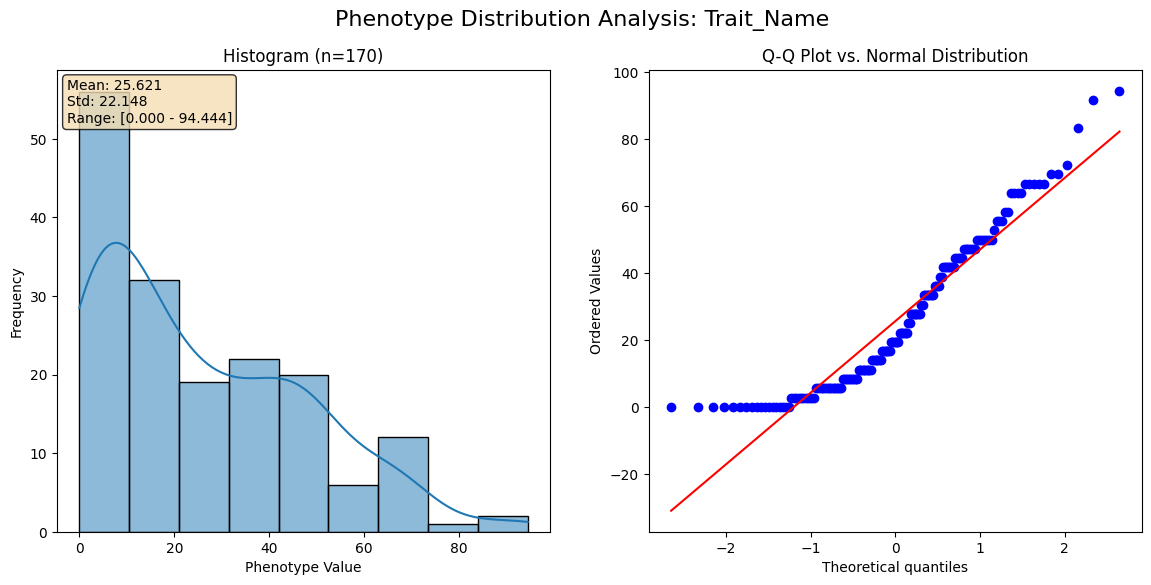

[2025-09-10 15:43:21] [INFO] Shapiro-Wilk normality test: p-value = 0.0000
[2025-09-10 15:43:21] [WARNING] Phenotype distribution significantly deviates from normal.
[2025-09-10 15:43:21] [INFO] Phenotype is skewed and transformation is enabled. Applying correction...
[2025-09-10 15:43:21] [INFO] Attempting to find the best transformation to normalize the phenotype...
[2025-09-10 15:43:21] [INFO] Testing 'sqrt' transformation... Shapiro-Wilk p-value: 0.0003
[2025-09-10 15:43:21] [INFO] Selected 'sqrt' transformation as it resulted in the most normal distribution (p=0.0003).
[2025-09-10 15:43:21] [INFO] Re-analyzing distribution of the 'sqrt' transformed phenotype.
[2025-09-10 15:43:21] [INFO] Analyzing phenotype distribution for 'Trait_Name (sqrt-transformed)'...


c:\Users\Saumya Dwivedi\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


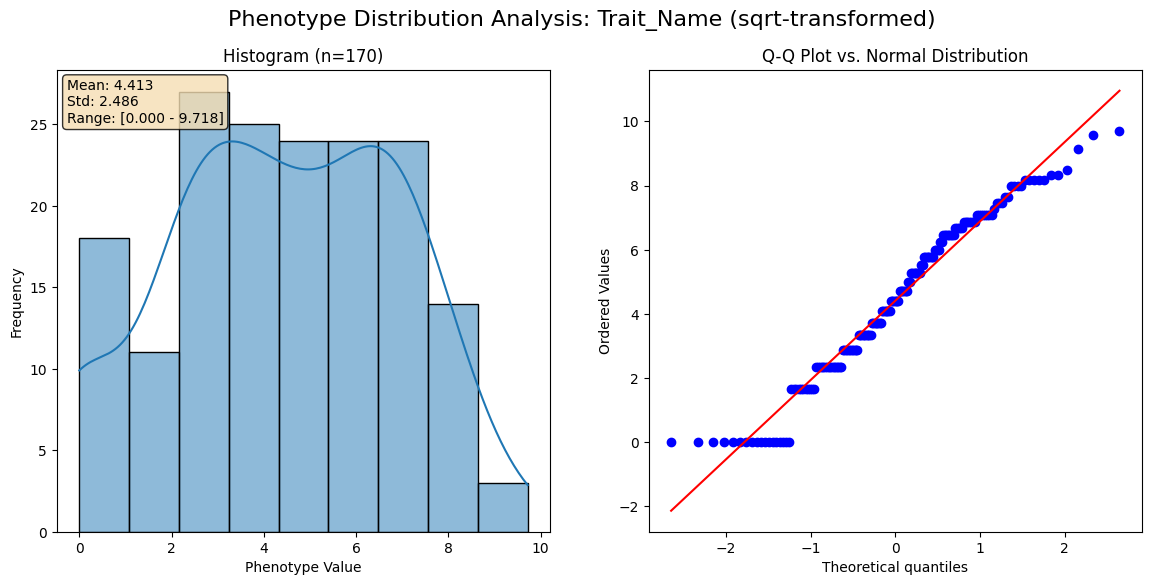

[2025-09-10 15:43:22] [INFO] Shapiro-Wilk normality test: p-value = 0.0003
[2025-09-10 15:43:22] [WARNING] Phenotype distribution significantly deviates from normal.

--- Transformed Phenotype Data Snippet ---


Sample
OAR1    6.871843
OAR2    5.527708
OAR3    3.726780
OAR4    6.009252
OAR5    6.666667
Name: phenotype, dtype: float64

[2025-09-10 15:43:22] [INFO] Proceeding with the final phenotype data for downstream analysis.


In [24]:
# ==========================================================
# Step 4.2: Phenotype Distribution Check and Transformation
# ==========================================================

#If `CHECK_PHENOTYPE_DISTRIBUTION` is `True`, this cell will visualize the trait's distribution and test for normality. This is a critical step to ensure the assumptions of the linear models are met.

if CHECK_PHENOTYPE_DISTRIBUTION:
    is_skewed = check_phenotype_distribution(pheno_series, trait_name=TRAIT_NAME)

    # If skewed and transformation is enabled, apply the best transformation
    if is_skewed and TRANSFORM_PHENOTYPE_IF_SKEWED:
        log_message("Phenotype is skewed and transformation is enabled. Applying correction...", "INFO")
        pheno_series, transform_name = apply_best_phenotype_transformation(pheno_series)

        if transform_name != "none":
            log_message(f"Re-analyzing distribution of the '{transform_name}' transformed phenotype.", "INFO")
            # Check the distribution of the new, transformed data
            check_phenotype_distribution(pheno_series, trait_name=f"{TRAIT_NAME} ({transform_name}-transformed)")
            print("\n--- Transformed Phenotype Data Snippet ---")
            display(pheno_series.head())
    elif is_skewed:
        log_message("SUGGESTION: Phenotype is skewed. Consider setting TRANSFORM_PHENOTYPE_IF_SKEWED = True for more robust results.", "WARNING")

log_message("Proceeding with the final phenotype data for downstream analysis.")

In [25]:
# ==========================================================
# Step 4.3: Quality Control
# ==========================================================

try:
    import ipywidgets as widgets
    from IPython.display import display as ipy_display

    def interactive_qc_table(qc_report):
        snp_df = qc_report['final_snp_metadata']
        sample_count = qc_report['step_counts'].get('samples_final', 0)
        snp_count = qc_report['step_counts'].get('snps_final', 0)
        print(f"\nInteractive QC Table: {snp_count} SNPs, {sample_count} samples")
        ipy_display(snp_df)
except ImportError:
    def interactive_qc_table(qc_report):
        print("ipywidgets not installed. Skipping interactive QC table.")

# --- Replace your QC step with this ---
G_qc, y, qc_snp_ids, snp_metadata, qc_report = perform_qc_plink_style(
    geno_df, pheno_series, snp_meta_base,
    MAF_THRESHOLD, IMPUTATION_METHOD, MIN_SNPS_PER_CHROMOSOME,
    remove_outliers=REMOVE_PHENOTYPE_OUTLIERS,
    outlier_method=OUTLIER_METHOD,
    outlier_threshold=OUTLIER_THRESHOLD
)

consolidated_qc_summary(qc_report)
report_phenotype_outliers(qc_report)
report_sample_dropout(qc_report)
report_snp_dropout(qc_report)
interactive_qc_table(qc_report)


C:\Users\Saumya Dwivedi\AppData\Local\Temp\ipykernel_1160\3644243661.py:219: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  G = geno_df.applymap(lambda x: np.nan if pd.isna(x) else x).values.astype(float)



COMPREHENSIVE QC SUMMARY
Samples before QC: 170
SNPs before QC: 1008
Samples after matching: 170
Samples removed (missing phenotype): 0
Samples removed (outliers): 0
SNPs removed (all missing): 4
SNPs removed (MAF filter): 79
SNPs removed (invalid chromosome): 0
SNPs consolidated to Chr 0: 0
Final samples: 170
Final SNPs: 925
No phenotype outliers removed.
No samples removed due to missing phenotype.

SNPs Removed (All Missing Genotypes): 4


,SNP_ID
0,IRRI_SNP3012_MSU7_2_19366631_C-A
1,IRRI_SNP3025_MSU7_4_19841904_T-C
2,IRRI_SNP3027_Chalk5_5.1
3,IRRI_SNP3102_MSU7_10_18835815_C-A



SNPs Removed (MAF Filter): 79


,SNP_ID
0,IRRI_SNP3008_tms5-STOP
1,IRRI_SNP1008_QSES1-2_4
2,IRRI_SNP1010_DTY2-2_2
3,IRRI_SNP1012_DTY2-2_4
4,IRRI_SNP1017_DTY3-2-N22_1
...,...
74,IRRI_SNP0982_CHR12_24417433
75,IRRI_SNP0985_CHR12_25490919
76,IRRI_SNP0986_CHR12_25756224
77,IRRI_SNP0987_CHR12_26259494


No SNPs removed due to invalid chromosome.
No SNPs removed due to consolidated to chr 0.

Interactive QC Table: 925 SNPs, 170 samples


,SNP_ID,chrom,pos
0,IRRI_SNP0994_SALTOL-AUS,0,801
1,IRRI_SNP0995_SALTOL-ARO,0,802
2,IRRI_SNP1018_GS3,0,821
3,IRRI_SNP1033_COLD1-JAP,0,832
4,IRRI_SNP1034_NAL1,0,833
...,...,...,...
920,IRRI_SNP0978_CHR12_23828922,12,23828922
921,IRRI_SNP0979_CHR12_24088209,12,24088209
922,IRRI_SNP0984_CHR12_24913573,12,24913573
923,IRRI_SNP0988_CHR12_26463351,12,26463351


[2025-09-10 15:43:23] [INFO] Using 10 PCs as specified in configuration.
[2025-09-10 15:43:23] [INFO] Running PCA for population structure analysis...
[2025-09-10 15:43:23] [INFO] Determining optimal number of PCs using the elbow method...


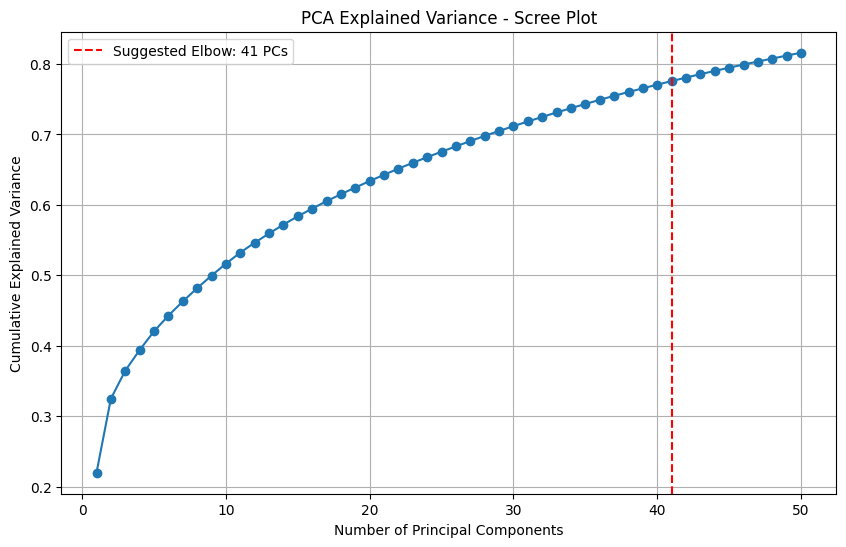

[2025-09-10 15:43:23] [INFO] Elbow method suggests using 41 PCs.
[2025-09-10 15:43:23] [INFO] Using 41 Principal Components for correction.
[2025-09-10 15:43:23] [INFO] PCA complete. Proceeding with 41 PCs.


In [26]:
# ==========================================================
# Step 4.4: Run Principal Component Analysis (PCA)
# ==========================================================

# *Calculates PCs to capture population structure. If `AUTO_SELECT_PCS` is `True`, it will also plot the explained variance to help choose the right number of PCs.

if 'NUM_PCS' in globals() and isinstance(NUM_PCS, int) and NUM_PCS > 0:
    log_message(f"Using {NUM_PCS} PCs as specified in configuration.")

PCs, num_pcs_used = run_pca(G_qc, NUM_PCS, AUTO_SELECT_PCS)
log_message(f"PCA complete. Proceeding with {num_pcs_used} PCs.")

[2025-09-10 15:43:23] [INFO] === Running Naive GLM ===
[2025-09-10 15:43:23] [INFO] Running Naive GLM (no covariates)...
[2025-09-10 15:43:24] [INFO] Naive GLM complete.
[2025-09-10 15:43:24] [INFO] Generating QQ plot for Naive GLM...


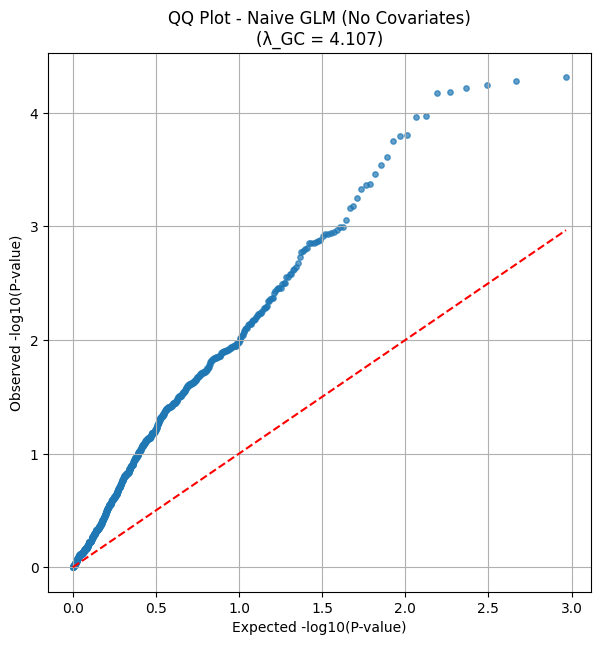

[2025-09-10 15:43:24] [INFO] Genomic Inflation Factor (λ_GC) for 'QQ Plot - Naive GLM (No Covariates)': 4.107
[2025-09-10 15:43:24] [WARNING] SUGGESTION: Lambda GC is high, indicating potential population stratification. The LMM or LOCO-LMM models are strongly recommended to correct for this.
[2025-09-10 15:43:24] [INFO] === Running PCA-Corrected GLM ===
[2025-09-10 15:43:24] [INFO] Running PCA-corrected GLM...
[2025-09-10 15:43:27] [INFO] PCA-corrected GLM complete.
[2025-09-10 15:43:27] [INFO] Generating QQ plot for PCA-corrected GLM...


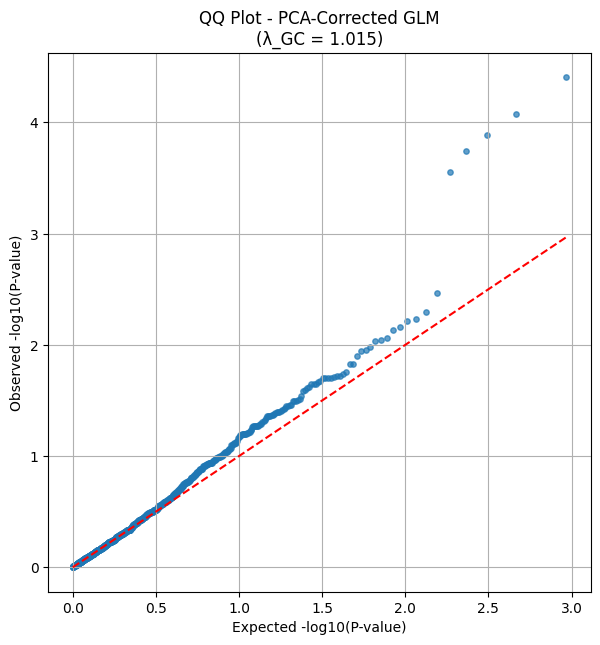

[2025-09-10 15:43:27] [INFO] Genomic Inflation Factor (λ_GC) for 'QQ Plot - PCA-Corrected GLM': 1.015
[2025-09-10 15:43:27] [INFO] SUGGESTION: Lambda GC is close to 1.0, indicating the model has likely controlled for population structure well.
[2025-09-10 15:43:27] [INFO] === Running Linear Mixed Model ===
[2025-09-10 15:43:27] [INFO] Running LMM GWAS model...
[2025-09-10 15:43:27] [INFO]   Building genome-wide kinship matrix...
[2025-09-10 15:43:27] [INFO]     Using all 925 SNPs for kinship matrix
[2025-09-10 15:43:27] [INFO]     Will test all 925 SNPs
[2025-09-10 15:43:27] [INFO]     Calculating kinship matrix...
[2025-09-10 15:43:27] [INFO]     Performing eigendecomposition of kinship matrix...
[2025-09-10 15:43:27] [INFO]     Estimating variance components using REML...
[2025-09-10 15:43:27] [INFO]     Estimated heritability (h²): 0.7697 (delta: 0.299155)
[2025-09-10 15:43:27] [INFO]     Testing 925 SNPs...
[2025-09-10 15:43:29] [INFO]     Chromosome genome-wide testing complete
[2

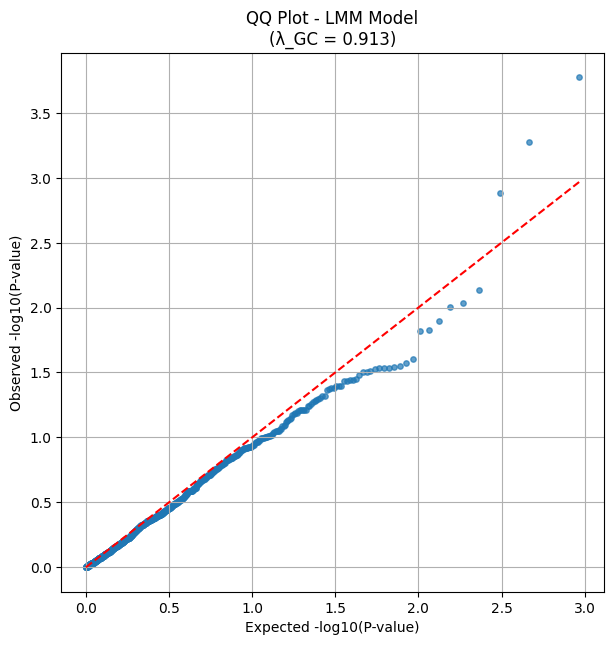

[2025-09-10 15:43:30] [INFO] Genomic Inflation Factor (λ_GC) for 'QQ Plot - LMM Model': 0.913
[2025-09-10 15:43:30] [WARNING] SUGGESTION: Lambda GC is low, which could indicate over-correction or other issues with the model assumptions.
[2025-09-10 15:43:30] [INFO] === Running LOCO-LMM ===
[2025-09-10 15:43:30] [INFO] Running LOCO-LMM GWAS model...
[2025-09-10 15:43:30] [INFO] LOCO mode: Will analyze 13 chromosomes separately
[2025-09-10 15:43:30] [INFO]   [LOCO] Processing chromosome 0...
[2025-09-10 15:43:30] [INFO]     Building kinship matrix from 725 SNPs on other chromosomes
[2025-09-10 15:43:30] [INFO]     Will test 200 SNPs on chromosome 0
[2025-09-10 15:43:30] [INFO]     Calculating kinship matrix...
[2025-09-10 15:43:30] [INFO]     Performing eigendecomposition of kinship matrix...
[2025-09-10 15:43:30] [INFO]     Estimating variance components using REML...
[2025-09-10 15:43:30] [INFO]     Estimated heritability (h²): 0.7857 (delta: 0.272728)
[2025-09-10 15:43:30] [INFO]     

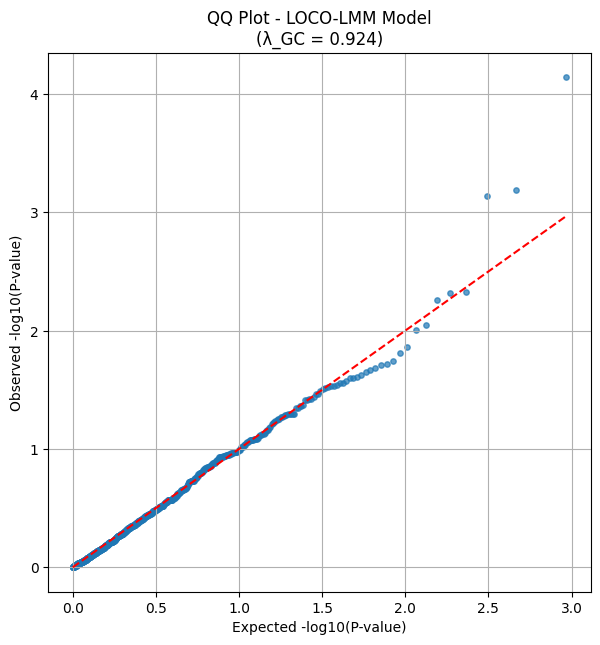

[2025-09-10 15:43:34] [INFO] Genomic Inflation Factor (λ_GC) for 'QQ Plot - LOCO-LMM Model': 0.924
[2025-09-10 15:43:34] [WARNING] SUGGESTION: Lambda GC is low, which could indicate over-correction or other issues with the model assumptions.

--- Results DataFrame Snippet ---


,SNP_ID,chrom,pos,p_value_naive,p_value_pca,p_value_lmm,p_value_loco
0,IRRI_SNP0994_SALTOL-AUS,0,801,0.283728,0.223330,0.097858,0.106841
1,IRRI_SNP0995_SALTOL-ARO,0,802,0.587137,0.197459,0.365857,0.357171
2,IRRI_SNP1018_GS3,0,821,0.003882,0.095541,0.055226,0.038283
3,IRRI_SNP1033_COLD1-JAP,0,832,0.676657,0.860028,0.953361,0.809987
4,IRRI_SNP1034_NAL1,0,833,0.686354,0.672325,0.513549,0.420509


[2025-09-10 15:43:34] [INFO] Generating comprehensive model comparison...


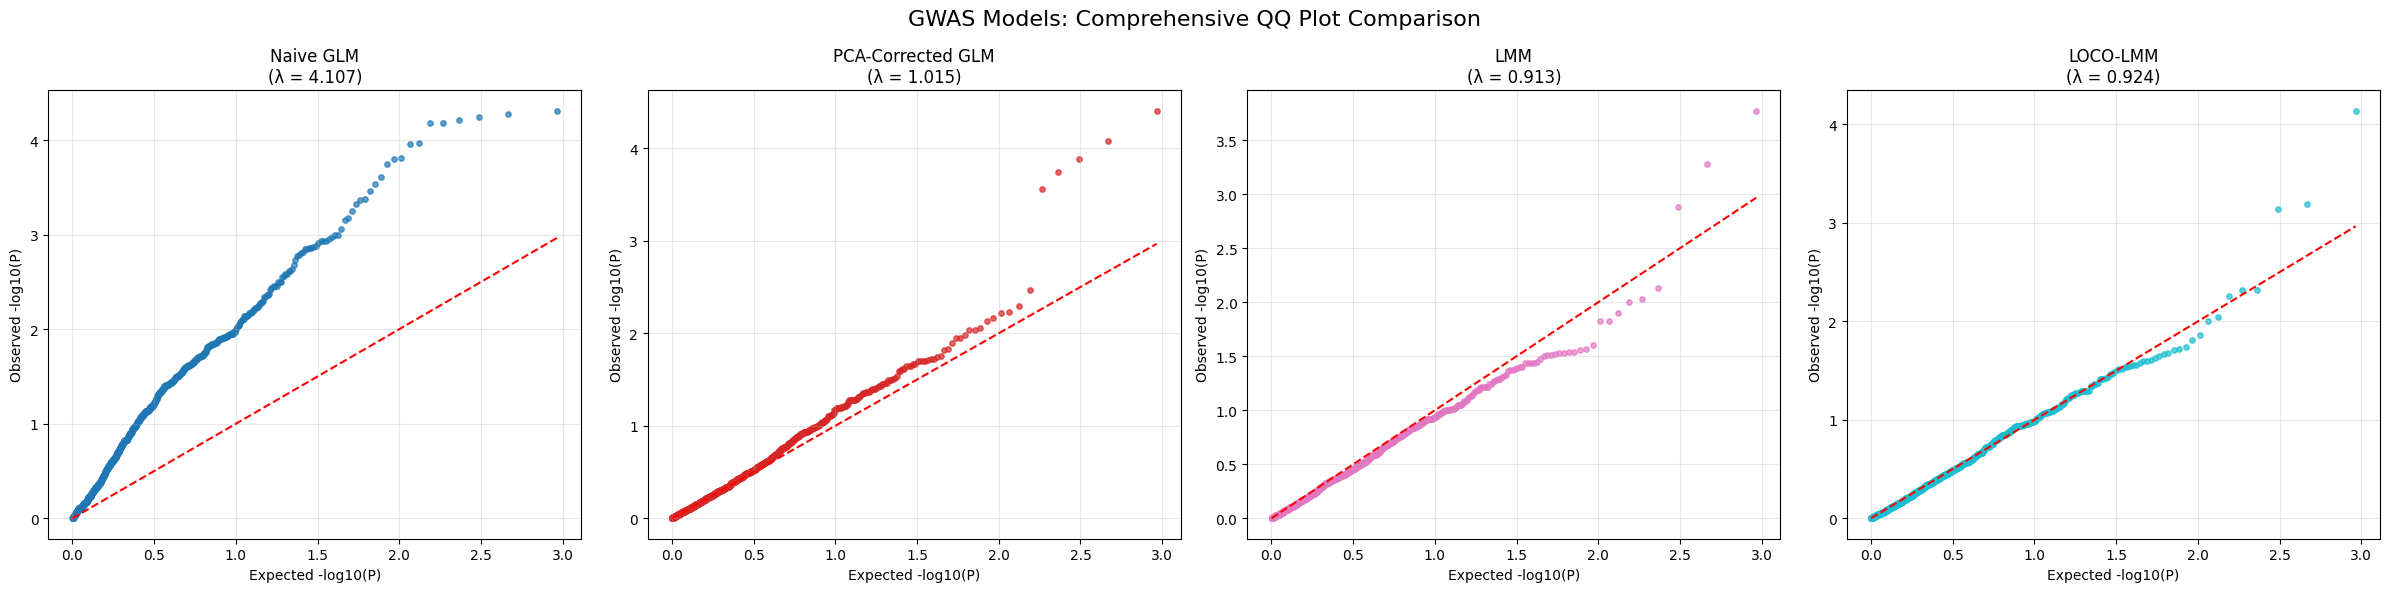

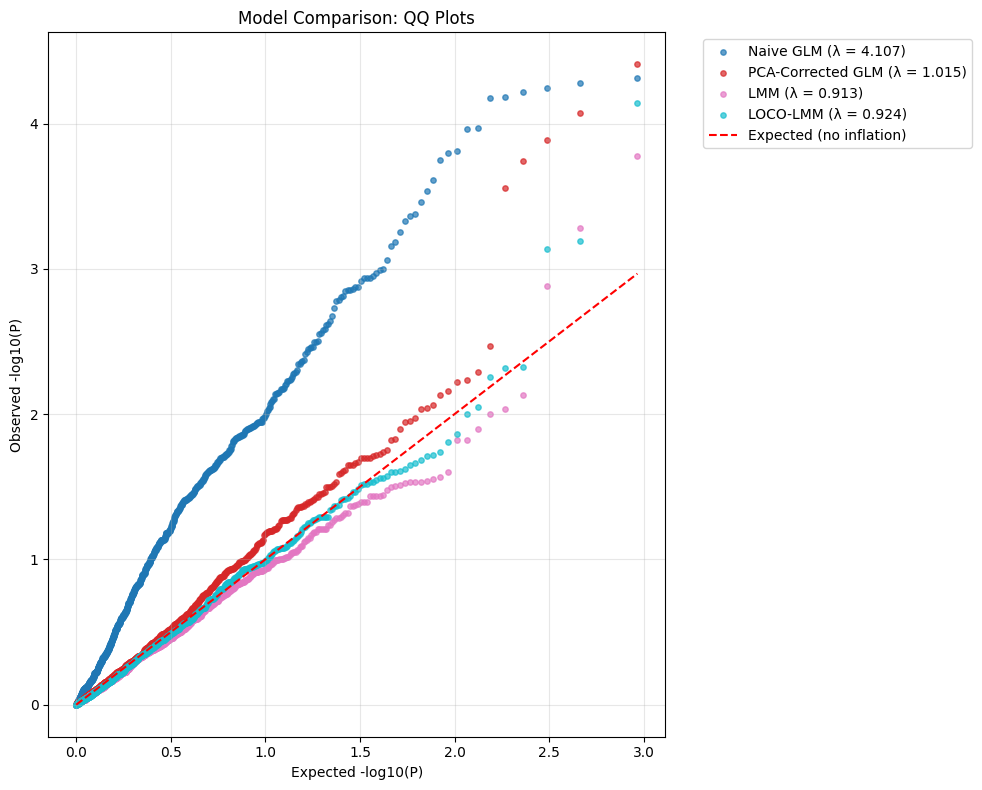


GENOMIC INFLATION FACTOR (λ) COMPARISON
Naive GLM           : λ = 4.107
                      🔴 HIGH INFLATION - Significant population structure
PCA-Corrected GLM   : λ = 1.015
                      ✅ WELL CALIBRATED - Good structure control
LMM                 : λ = 0.913
                      🟡 DEFLATED - Possible over-correction
LOCO-LMM            : λ = 0.924
                      🟡 DEFLATED - Possible over-correction

📊 MODEL EFFECTIVENESS RANKING:
   1. PCA-Corrected GLM (λ = 1.015)
   2. LOCO-LMM (λ = 0.924)
   3. LMM (λ = 0.913)
   4. Naive GLM (λ = 4.107)

🎯 KEY INSIGHTS:
   → PCA correction reduced λ by 3.091
   → This indicates significant population structure was present
   → Mixed models provide additional correction for relatedness
   → Most calibrated model: PCA-Corrected GLM


In [27]:
# =================================================
# Step 4.5a: Run GWAS Models with Enhanced Analysis
# =================================================

# This section runs the selected GWAS models and provides comprehensive comparisons.

results_df = snp_metadata.copy()
qq_data = {}  # Store p-values for comparative QQ plots

# --- Model A: Naive GLM (No covariates) ---
if RUN_NAIVE_GLM:
    log_message("=== Running Naive GLM ===")
    p_naive = run_gwas_naive(G_qc, y)
    results_df['p_value_naive'] = p_naive
    qq_data['Naive GLM'] = p_naive

    # Individual QQ plot for Naive GLM
    log_message("Generating QQ plot for Naive GLM...")
    plot_qq(p_naive, "QQ Plot - Naive GLM (No Covariates)")

# --- Model B: PCA-Corrected GLM ---
if RUN_PCA_GLM:
    log_message("=== Running PCA-Corrected GLM ===")
    p_pca = run_gwas_pca(G_qc, y, PCs)
    results_df['p_value_pca'] = p_pca
    qq_data['PCA-Corrected GLM'] = p_pca

    # Individual QQ plot for PCA-corrected GLM
    log_message("Generating QQ plot for PCA-corrected GLM...")
    plot_qq(p_pca, "QQ Plot - PCA-Corrected GLM")

# --- Model C: Linear Mixed Model (LMM) ---
if RUN_LMM:
    log_message("=== Running Linear Mixed Model ===")
    p_lmm = run_gwas_lmm(G_qc, y, PCs, snp_metadata, loco=False)
    results_df['p_value_lmm'] = p_lmm
    qq_data['LMM'] = p_lmm

    # Individual QQ plot for LMM
    log_message("Generating QQ plot for LMM...")
    plot_qq(p_lmm, "QQ Plot - LMM Model")

# --- Model D: Leave-One-Chromosome-Out LMM (LOCO-LMM) ---
if RUN_LOCO_LMM:
    log_message("=== Running LOCO-LMM ===")
    p_loco = run_gwas_lmm(G_qc, y, PCs, snp_metadata, loco=True)
    results_df['p_value_loco'] = p_loco
    qq_data['LOCO-LMM'] = p_loco

    # Individual QQ plot for LOCO-LMM
    log_message("Generating QQ plot for LOCO-LMM...")
    plot_qq(p_loco, "QQ Plot - LOCO-LMM Model")

print("\n--- Results DataFrame Snippet ---")
display(results_df.head())

# ==========================================
# Step 4.5b: Comprehensive Model Comparison
# ==========================================

# Generate comparative visualizations to assess model performance

def plot_comparative_qq(qq_data_dict, title="Comparative QQ Plots"):
    """
    Creates side-by-side QQ plots and a combined comparison plot.
    """
    n_models = len(qq_data_dict)
    if n_models == 0:
        return

    # Calculate lambda values for all models
    lambda_values = {}
    for model_name, p_values in qq_data_dict.items():
        p_clean = pd.Series(p_values).dropna()
        if not p_clean.empty:
            chisq = stats.chi2.ppf(1 - p_clean, 1)
            lambda_gc = np.median(chisq) / stats.chi2.ppf(0.5, 1)
            lambda_values[model_name] = lambda_gc

    # Individual QQ plots side by side
    fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 6))
    if n_models == 1:
        axes = [axes]

    colors = plt.cm.tab10(np.linspace(0, 1, n_models))

    for idx, (model_name, p_values) in enumerate(qq_data_dict.items()):
        ax = axes[idx]
        p_clean = pd.Series(p_values).dropna()

        if not p_clean.empty:
            p_sorted = np.sort(p_clean)
            observed = -np.log10(p_sorted)
            expected = -np.log10(np.arange(1, len(p_sorted) + 1) / (len(p_sorted) + 1))

            ax.scatter(expected, observed, s=15, alpha=0.7, color=colors[idx])
            ax.plot([0, expected.max()], [0, expected.max()], color='red', linestyle='--')

            lambda_val = lambda_values.get(model_name, np.nan)
            ax.set_title(f"{model_name}\n(λ = {lambda_val:.3f})")
            ax.set_xlabel("Expected -log10(P)")
            ax.set_ylabel("Observed -log10(P)")
            ax.grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

    # Combined comparison plot
    if n_models > 1:
        plt.figure(figsize=(10, 8))

        for idx, (model_name, p_values) in enumerate(qq_data_dict.items()):
            p_clean = pd.Series(p_values).dropna()

            if not p_clean.empty:
                p_sorted = np.sort(p_clean)
                observed = -np.log10(p_sorted)
                expected = -np.log10(np.arange(1, len(p_sorted) + 1) / (len(p_sorted) + 1))

                lambda_val = lambda_values.get(model_name, np.nan)
                plt.scatter(expected, observed, s=15, alpha=0.7,
                          label=f"{model_name} (λ = {lambda_val:.3f})", color=colors[idx])

        # Add diagonal line
        if qq_data_dict:
            max_expected = max([np.max(-np.log10(np.arange(1, len(pd.Series(p).dropna()) + 1) /
                                                (len(pd.Series(p).dropna()) + 1)))
                              for p in qq_data_dict.values() if len(pd.Series(p).dropna()) > 0])
            plt.plot([0, max_expected], [0, max_expected], color='red', linestyle='--',
                    label='Expected (no inflation)')

        plt.xlabel("Expected -log10(P)")
        plt.ylabel("Observed -log10(P)")
        plt.title("Model Comparison: QQ Plots")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Lambda interpretation
    print("\n" + "="*60)
    print("GENOMIC INFLATION FACTOR (λ) COMPARISON")
    print("="*60)

    for model_name, lambda_val in lambda_values.items():
        print(f"{model_name:20s}: λ = {lambda_val:.3f}")
        if lambda_val > 1.10:
            print(f"{'':20s}  🔴 HIGH INFLATION - Significant population structure")
        elif lambda_val > 1.05:
            print(f"{'':20s}  🟡 MODERATE INFLATION - Some population structure")
        elif lambda_val >= 0.95:
            print(f"{'':20s}  ✅ WELL CALIBRATED - Good structure control")
        else:
            print(f"{'':20s}  🟡 DEFLATED - Possible over-correction")

    if len(lambda_values) > 1:
        print(f"\n📊 MODEL EFFECTIVENESS RANKING:")
        sorted_models = sorted(lambda_values.items(), key=lambda x: abs(x[1] - 1.0))
        for i, (model_name, lambda_val) in enumerate(sorted_models, 1):
            print(f"   {i}. {model_name} (λ = {lambda_val:.3f})")

        print(f"\n🎯 KEY INSIGHTS:")
        if 'Naive GLM' in lambda_values and 'PCA-Corrected GLM' in lambda_values:
            naive_lambda = lambda_values['Naive GLM']
            pca_lambda = lambda_values['PCA-Corrected GLM']
            improvement = naive_lambda - pca_lambda
            print(f"   → PCA correction reduced λ by {improvement:.3f}")
            if improvement > 0.05:
                print(f"   → This indicates significant population structure was present")

        if any('LMM' in model for model in lambda_values):
            print(f"   → Mixed models provide additional correction for relatedness")

        best_model = sorted_models[0][0]
        print(f"   → Most calibrated model: {best_model}")

        return lambda_values

# Generate comprehensive model comparison
if len(qq_data) > 0:
    log_message("Generating comprehensive model comparison...")
    lambda_values = plot_comparative_qq(qq_data, "GWAS Models: Comprehensive QQ Plot Comparison")

In [28]:
# =======================================================
# Step 4.6: Correction, Summary, Suggestions, and Saving
# =======================================================

# *Performs multiple testing correction (FDR), generates a summary table comparing the models, and saves the full results to a CSV file. Includes a data-driven model recommendation.*

log_message("Performing multiple testing correction (FDR)...")
n_snps_final = G_qc.shape[1]
bonferroni_threshold = SIGNIFICANCE_ALPHA / n_snps_final

# Initialize summary data
summary_data = []

# Determine which models were run
model_methods = []
if RUN_NAIVE_GLM:
    model_methods.append('naive')
if RUN_PCA_GLM:
    model_methods.append('pca')
if RUN_LMM:
    model_methods.append('lmm')
if RUN_LOCO_LMM:
    model_methods.append('loco')

log_message(f"Applying FDR correction to {len(model_methods)} models: {', '.join([m.upper() for m in model_methods])}")

# Apply FDR correction for each model
for method in model_methods:
    p_col = f'p_value_{method}'
    q_col = f'q_value_{method}'

    log_message(f"  Processing {method.upper()} model...")

    results_df[q_col] = np.nan

    if p_col not in results_df.columns:
        log_message(f"    Warning: {p_col} column not found. Skipping FDR correction for {method.upper()}.", "WARNING")
        continue

    valid_mask = results_df[p_col].notna() & np.isfinite(results_df[p_col])
    n_valid = valid_mask.sum()

    if n_valid == 0:
        log_message(f"    Warning: No valid p-values found for {method.upper()}. Skipping FDR correction.", "WARNING")
        continue

    log_message(f"    Found {n_valid} valid p-values out of {len(results_df)} total SNPs")

    p_vals_valid = results_df.loc[valid_mask, p_col].values

    try:
        rejected, q_values, _, _ = multipletests(
            p_vals_valid, alpha=SIGNIFICANCE_ALPHA, method='fdr_bh'
        )
        results_df.loc[valid_mask, q_col] = q_values
        log_message(f"    FDR correction complete for {method.upper()}")
        log_message(f"    - Number of rejections at FDR {SIGNIFICANCE_ALPHA}: {rejected.sum()}")

    except Exception as e:
        log_message(f"    Error during FDR correction for {method.upper()}: {e}", "ERROR")
        continue

# --- Generate summary statistics ---
log_message("Generating summary statistics...")
for method in model_methods:
    p_col = f'p_value_{method}'
    q_col = f'q_value_{method}'

    if p_col not in results_df.columns:
        continue

    bonf_sig = (results_df[p_col] < bonferroni_threshold).sum()
    fdr_sig = (results_df[q_col] < SIGNIFICANCE_ALPHA).sum() if q_col in results_df.columns else 0
    total_tests = results_df[p_col].notna().sum()
    min_p = results_df[p_col].min() if total_tests > 0 else np.nan

    summary_data.append({
        "Method": method.upper(),
        "Total Tests": int(total_tests),
        f"Bonferroni Hits (p<{bonferroni_threshold:.1e})": int(bonf_sig),
        f"FDR Hits (q<{SIGNIFICANCE_ALPHA})": int(fdr_sig),
        "Min P-value": f"{min_p:.2e}" if pd.notna(min_p) else "N/A"
    })

summary_df = pd.DataFrame(summary_data)
log_message("--- GWAS Final Summary ---")
if not summary_df.empty:
    print(summary_df.to_string(index=False))
else:
    log_message("No models were successfully run. Summary table is empty.", "WARNING")

output_file = f"{OUTPUT_PREFIX}_gwas_results.csv"
log_message(f"Saving detailed results to: {output_file}")
try:
    results_df.to_csv(output_file, index=False)
    log_message(f"Results successfully saved to {output_file}")
except Exception as e:
    log_message(f"Error saving results: {e}", "ERROR")

# --- Enhanced Interpretation and Suggestions ---
if len(summary_df) > 1:
    print("\n" + "="*60)
    print("INTERPRETATION & SUGGESTIONS")
    print("="*60)

    # Compare Naive vs PCA if both were run
    if 'NAIVE' in summary_df['Method'].values and 'PCA' in summary_df['Method'].values:
        naive_hits = summary_df.loc[summary_df['Method'] == 'NAIVE', f"FDR Hits (q<{SIGNIFICANCE_ALPHA})"].iloc[0]
        pca_hits = summary_df.loc[summary_df['Method'] == 'PCA', f"FDR Hits (q<{SIGNIFICANCE_ALPHA})"].iloc[0]

        print(f"📊 POPULATION STRUCTURE ASSESSMENT:")
        if naive_hits > pca_hits * 1.5:
            print(f"   ✓ Substantial reduction from {naive_hits} to {pca_hits} hits suggests population structure was a major confounder.")
        elif naive_hits > pca_hits:
            print(f"   ⚠ Modest reduction from {naive_hits} to {pca_hits} hits suggests some, but limited, population structure.")
        else:
            print(f"   ℹ Similar hits ({naive_hits} vs {pca_hits}) suggests population structure may not be a major issue.")

    # Compare PCA vs LMM if both were run
    if 'PCA' in summary_df['Method'].values and 'LMM' in summary_df['Method'].values:
        pca_hits = summary_df.loc[summary_df['Method'] == 'PCA', f"FDR Hits (q<{SIGNIFICANCE_ALPHA})"].iloc[0]
        lmm_hits = summary_df.loc[summary_df['Method'] == 'LMM', f"FDR Hits (q<{SIGNIFICANCE_ALPHA})"].iloc[0]

        print(f"\n🧬 CRYPTIC RELATEDNESS ASSESSMENT:")
        if pca_hits > lmm_hits * 1.2:
            print(f"   ✓ Reduction from {pca_hits} (PCA) to {lmm_hits} (LMM) hits suggests cryptic relatedness was a confounding factor.")
        else:
            print(f"   ℹ Similar hits ({pca_hits} vs {lmm_hits}) suggests cryptic relatedness is not a major issue beyond PCA correction.")

    # LOCO-LMM assessment
    if 'LOCO' in summary_df['Method'].values:
        loco_hits = summary_df.loc[summary_df['Method'] == 'LOCO', f"FDR Hits (q<{SIGNIFICANCE_ALPHA})"].iloc[0]
        print(f"\n🏆 GOLD STANDARD (LOCO-LMM) RESULTS:")
        print(f"   ✓ LOCO-LMM identified {loco_hits} significant associations, avoiding proximal contamination.")
        if 'LMM' in summary_df['Method'].values:
            lmm_hits = summary_df.loc[summary_df['Method'] == 'LMM', f"FDR Hits (q<{SIGNIFICANCE_ALPHA})"].iloc[0]
            if loco_hits < lmm_hits:
                print(f"   ⚠ Note: LOCO found fewer hits ({loco_hits}) than standard LMM ({lmm_hits}), suggesting some LMM signals may be inflated.")

# --- Model Recommendation  ---
print("\n" + "="*60)
print("🎯 MODEL RECOMMENDATION")
print("="*60)

best_model_name = None
recommendation_made = False

lambda_key_mapping = {
    'NAIVE': 'Naive GLM',
    'PCA': 'PCA-Corrected GLM',
    'LMM': 'LMM',
    'LOCO': 'LOCO-LMM'
}

if not summary_df.empty and 'lambda_values' in locals():
    model_preference = ['LOCO', 'LMM', 'PCA', 'NAIVE']

    for model in model_preference:
        if model in summary_df['Method'].values and summary_df.loc[summary_df['Method'] == model, 'Total Tests'].iloc[0] > 0:
            best_model_name = model
            break

    if best_model_name:
        lambda_key = lambda_key_mapping.get(best_model_name)
        best_model_lambda = lambda_values.get(lambda_key) if lambda_key else None
        lambda_str = f"λ = {best_model_lambda:.3f}" if best_model_lambda is not None else "λ not available"

        if best_model_name == 'LOCO' and best_model_lambda is not None and abs(best_model_lambda - 1.0) < 0.05:
            print(f"  → ✅ Focus on LOCO-LMM results ({lambda_str}). This is the most robust and well-calibrated model.")
        else:
            if best_model_name == 'LOCO':
                print(f"  → ⚠️ Focus on LOCO-LMM results, but with caution ({lambda_str}). Its inflation factor is not ideal.")
            elif best_model_name == 'LMM':
                print(f"  → Focus on LMM results ({lambda_str}). This corrects for relatedness. Consider LOCO-LMM for maximum rigor.")
            elif best_model_name == 'PCA':
                print(f"  → Use PCA-corrected results with caution ({lambda_str}). This does NOT correct for cryptic relatedness.")
            elif best_model_name == 'NAIVE':
                print(f"  → 🚨 CRITICAL: Only the NAIVE model has results ({lambda_str}). These are likely inflated and unreliable.")
        recommendation_made = True

if not recommendation_made:
    print("  → 🔴 No models completed successfully. Please check the log for errors.")


# --- Quality Control Flags ---
print(f"\n" + "="*60)
print("⚠️  QUALITY CONTROL FLAGS")
print("="*60)

if not summary_df.empty:
    total_snps_tested = summary_df["Total Tests"].max()
    max_hits = summary_df[f"FDR Hits (q<{SIGNIFICANCE_ALPHA})"].max()

    if total_snps_tested < n_snps_final * 0.8:
        print(f"  🔴 HIGH FAILURE RATE: Only {total_snps_tested}/{n_snps_final} SNPs successfully tested. Investigate model convergence issues.")
    else:
        print(f"  ✅ TESTING SUCCESS: {total_snps_tested}/{n_snps_final} SNPs successfully tested.")

    if total_snps_tested > 0:
        hit_rate = 100 * max_hits / total_snps_tested
        if hit_rate > 10:
            print(f"  🔴 VERY HIGH HIT RATE: {max_hits} significant SNPs ({hit_rate:.1f}%). May indicate insufficient correction.")
        elif hit_rate > 5:
            print(f"  🟡 HIGH HIT RATE: {max_hits} significant SNPs ({hit_rate:.1f}%). Verify that population structure is adequately controlled.")
        elif max_hits == 0:
            print(f"  🟡 NO SIGNIFICANT HITS: Consider investigating phenotype quality or genetic architecture.")
        else:
            print(f"  ✅ REASONABLE HIT RATE: {max_hits} significant SNPs ({hit_rate:.1f}%).")
else:
    print("  - No QC flags to report as no models were successfully run.")

print("="*60)

[2025-09-10 15:43:37] [INFO] Performing multiple testing correction (FDR)...
[2025-09-10 15:43:37] [INFO] Applying FDR correction to 4 models: NAIVE, PCA, LMM, LOCO
[2025-09-10 15:43:37] [INFO]   Processing NAIVE model...
[2025-09-10 15:43:37] [INFO]     Found 925 valid p-values out of 925 total SNPs
[2025-09-10 15:43:37] [INFO]     FDR correction complete for NAIVE
[2025-09-10 15:43:37] [INFO]     - Number of rejections at FDR 0.05: 41
[2025-09-10 15:43:37] [INFO]   Processing PCA model...
[2025-09-10 15:43:37] [INFO]     Found 925 valid p-values out of 925 total SNPs
[2025-09-10 15:43:37] [INFO]     FDR correction complete for PCA
[2025-09-10 15:43:37] [INFO]     - Number of rejections at FDR 0.05: 4
[2025-09-10 15:43:37] [INFO]   Processing LMM model...
[2025-09-10 15:43:37] [INFO]     Found 925 valid p-values out of 925 total SNPs
[2025-09-10 15:43:37] [INFO]     FDR correction complete for LMM
[2025-09-10 15:43:37] [INFO]     - Number of rejections at FDR 0.05: 0
[2025-09-10 15:43

[2025-09-10 15:43:37] [INFO] Generating Manhattan plots for all models...
[2025-09-10 15:43:37] [INFO] Threshold levels:
[2025-09-10 15:43:37] [INFO]   - Suggestive: p < 1e-05
[2025-09-10 15:43:37] [INFO]   - FDR: q < 0.05
[2025-09-10 15:43:37] [INFO]   - Bonferroni: p < 5.41e-05
[2025-09-10 15:43:37] [INFO] Generating Manhattan plot for NAIVE model...
[2025-09-10 15:43:37] [INFO] Generating Manhattan Plot for: Manhattan Plot - NAIVE Model


C:\Users\Saumya Dwivedi\AppData\Local\Temp\ipykernel_1160\4099714026.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chrom_max_pos = df_plot.groupby('chrom')['pos'].max().replace(0, 1)
C:\Users\Saumya Dwivedi\AppData\Local\Temp\ipykernel_1160\4099714026.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(sorted_chroms))


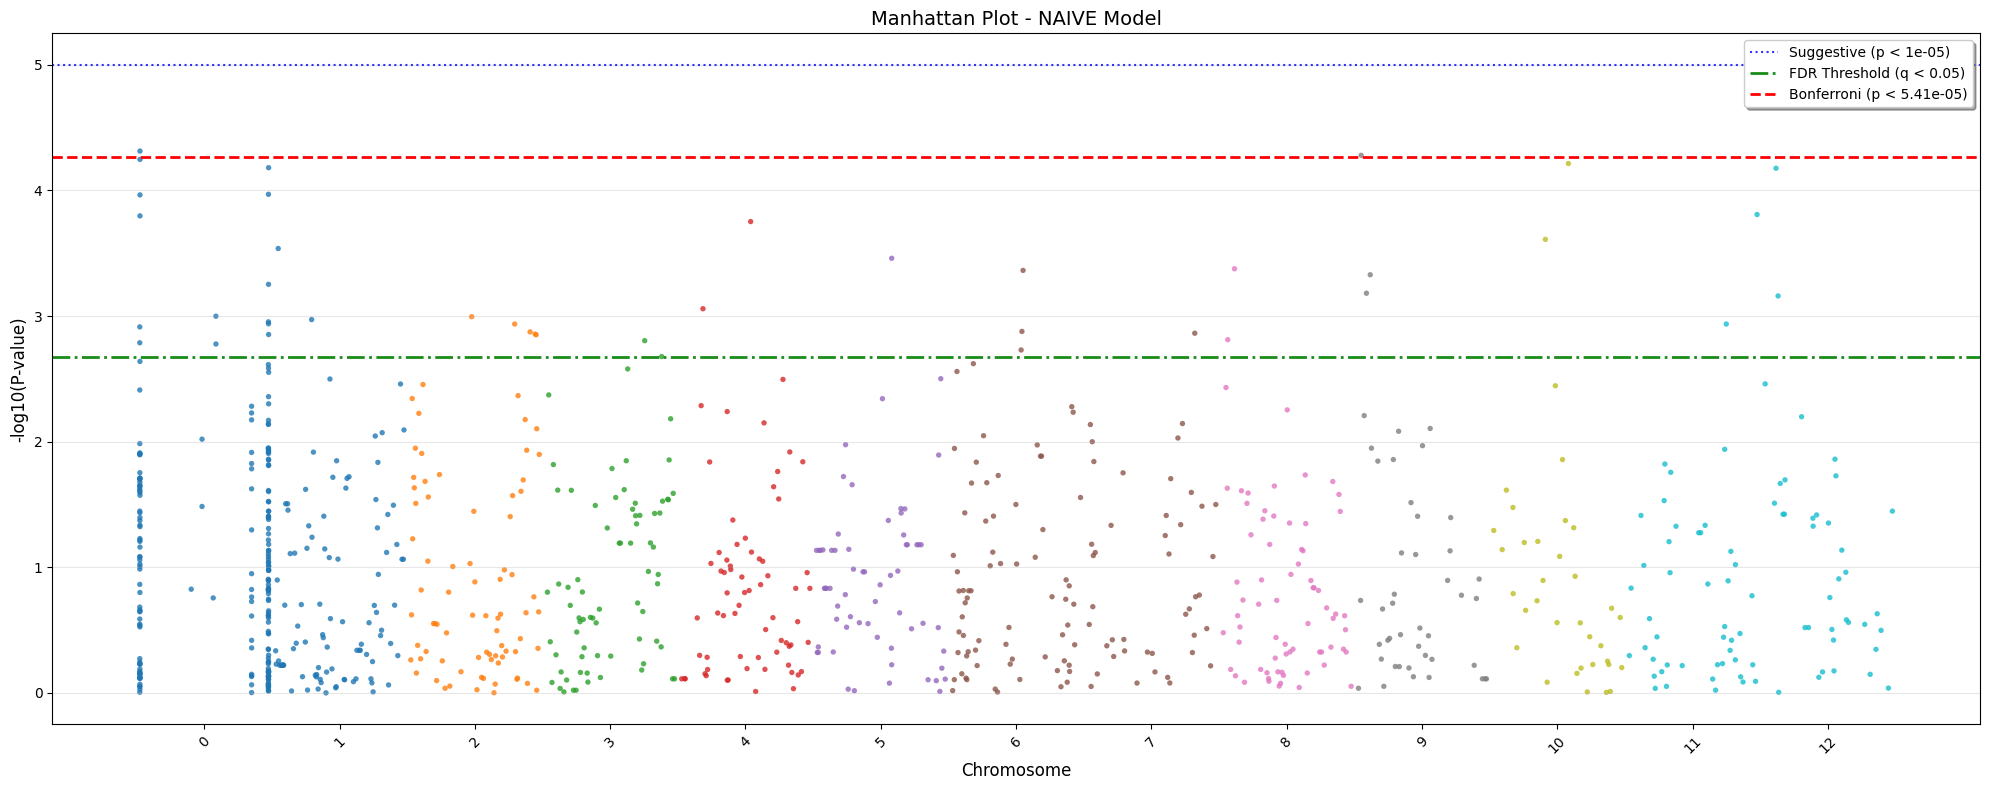

[2025-09-10 15:43:38] [INFO] Manhattan Plot Summary: 0 suggestive, 41 FDR significant, 2 Bonferroni significant SNPs
[2025-09-10 15:43:38] [INFO] Generating Manhattan plot for PCA model...
[2025-09-10 15:43:38] [INFO] Generating Manhattan Plot for: Manhattan Plot - PCA Model


C:\Users\Saumya Dwivedi\AppData\Local\Temp\ipykernel_1160\4099714026.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chrom_max_pos = df_plot.groupby('chrom')['pos'].max().replace(0, 1)
C:\Users\Saumya Dwivedi\AppData\Local\Temp\ipykernel_1160\4099714026.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(sorted_chroms))


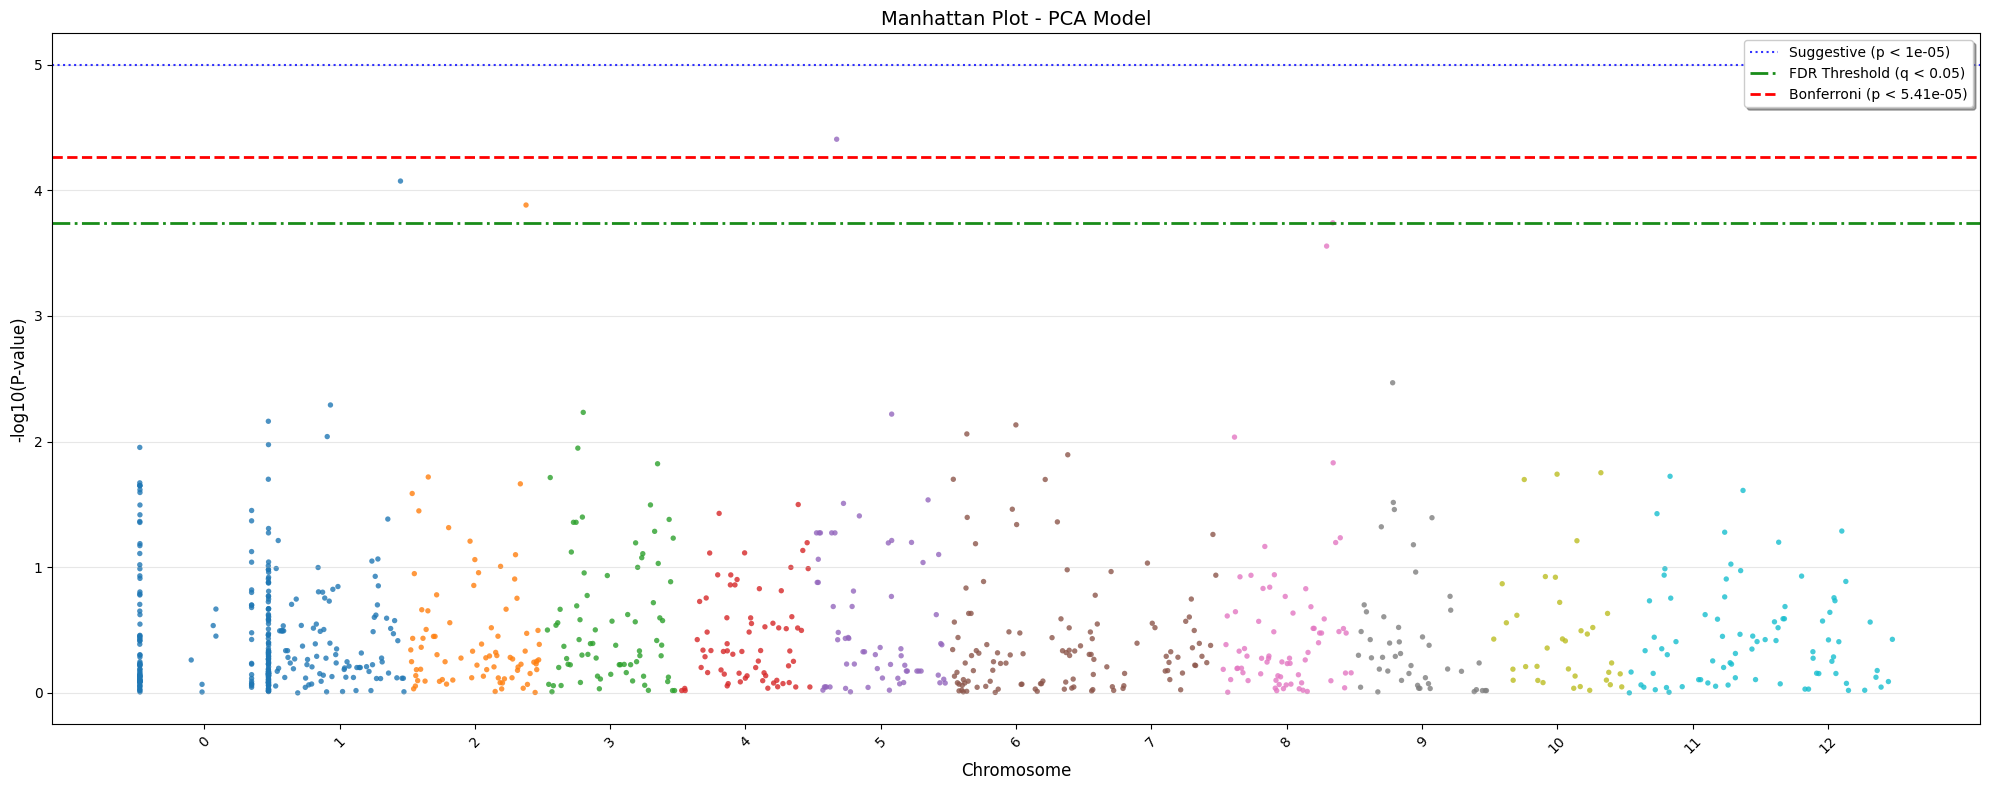

[2025-09-10 15:43:38] [INFO] Manhattan Plot Summary: 0 suggestive, 4 FDR significant, 1 Bonferroni significant SNPs
[2025-09-10 15:43:38] [INFO] Generating Manhattan plot for LMM model...
[2025-09-10 15:43:38] [INFO] Generating Manhattan Plot for: Manhattan Plot - LMM Model


C:\Users\Saumya Dwivedi\AppData\Local\Temp\ipykernel_1160\4099714026.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chrom_max_pos = df_plot.groupby('chrom')['pos'].max().replace(0, 1)
C:\Users\Saumya Dwivedi\AppData\Local\Temp\ipykernel_1160\4099714026.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(sorted_chroms))


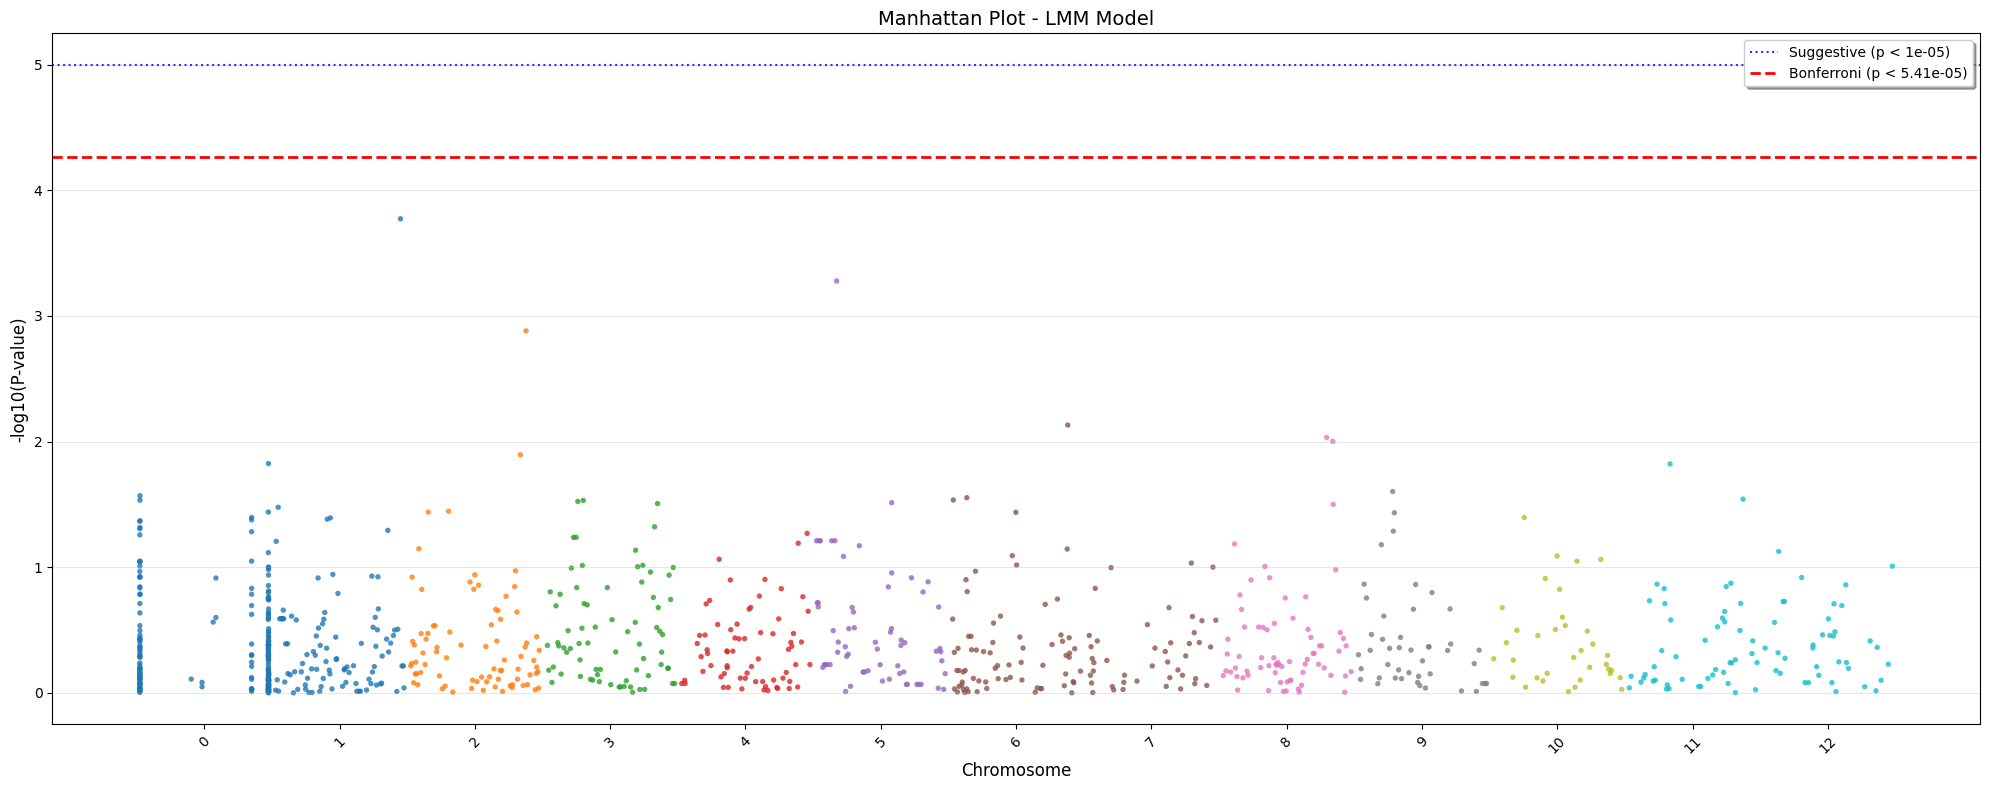

[2025-09-10 15:43:39] [INFO] Manhattan Plot Summary: 0 suggestive, 0 FDR significant, 0 Bonferroni significant SNPs
[2025-09-10 15:43:39] [INFO] Generating Manhattan plot for LOCO model...
[2025-09-10 15:43:39] [INFO] Generating Manhattan Plot for: Manhattan Plot - LOCO Model


C:\Users\Saumya Dwivedi\AppData\Local\Temp\ipykernel_1160\4099714026.py:53: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chrom_max_pos = df_plot.groupby('chrom')['pos'].max().replace(0, 1)
C:\Users\Saumya Dwivedi\AppData\Local\Temp\ipykernel_1160\4099714026.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(sorted_chroms))


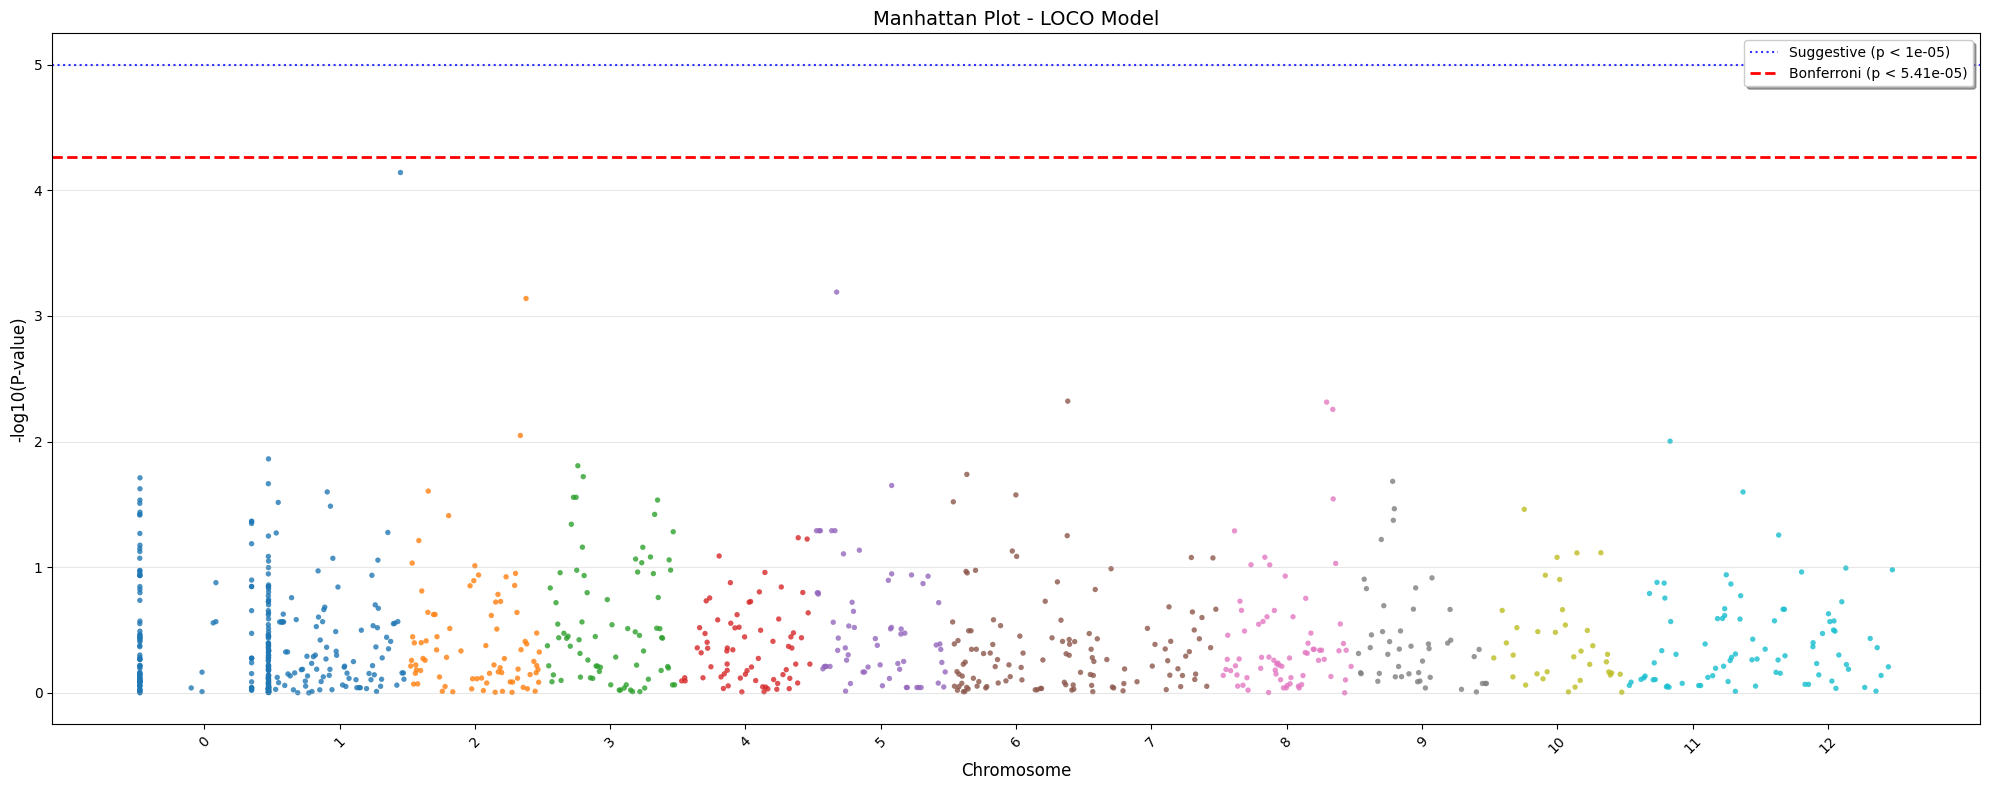

[2025-09-10 15:43:39] [INFO] Manhattan Plot Summary: 0 suggestive, 0 FDR significant, 0 Bonferroni significant SNPs
[2025-09-10 15:43:39] [INFO] Manhattan plot generation complete.


In [29]:
# ===============================
# Step 4.7: Final Visualizations
# ===============================

# Generates Manhattan plots for all completed models, providing a visual comparison of the results.

# Define suggestive threshold (commonly used in GWAS)
SUGGESTIVE_THRESHOLD = 1e-5  # p < 1e-5

log_message("Generating Manhattan plots for all models...")
log_message(f"Threshold levels:")
log_message(f"  - Suggestive: p < {SUGGESTIVE_THRESHOLD:.0e}")
log_message(f"  - FDR: q < {SIGNIFICANCE_ALPHA}")
log_message(f"  - Bonferroni: p < {bonferroni_threshold:.2e}")

for method in model_methods:
    p_col = f'p_value_{method}'
    q_col = f'q_value_{method}'

    if p_col in results_df.columns:
        log_message(f"Generating Manhattan plot for {method.upper()} model...")
        title_suffix = f"{method.upper()} Model"
        plot_manhattan(results_df, p_col, q_col,
                      f"Manhattan Plot - {title_suffix}",
                      bonferroni_threshold, SIGNIFICANCE_ALPHA, SUGGESTIVE_THRESHOLD)
    else:
        log_message(f"Skipping Manhattan plot for {method.upper()} - no p-values found", "WARNING")

log_message("Manhattan plot generation complete.")

In [30]:
# ==============================
# 5. FINAL BENCHMARKING REPORT
# ==============================

# This cell concludes the pipeline and reports the total runtime and peak memory usage if `BENCHMARK` was set to `True`.

end_time = time.time()
log_message(f"--- Pipeline Finished in {end_time - start_time:.2f} seconds ---")
if BENCHMARK:
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    log_message(f"Memory Usage: Peak = {format_bytes(peak)}")


[2025-09-10 15:43:39] [INFO] --- Pipeline Finished in 22.03 seconds ---
[2025-09-10 15:43:39] [INFO] Memory Usage: Peak = 13.19 MB
